In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tensornetworks_pytorch.TNModels import PosMPS, Born
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(torch.__version__)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
if DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0) / 1024**3, 1), 'GB')

1.8.0.dev20201128
Using device: cpu


In [2]:
### import data
import pickle
for dataset in ['biofam','flare','lymphography','spect','tumor','votes']:
    with open('datasets/'+dataset, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1' # biofam seemed to have an encoding issue which this fixes
        a = u.load()
    X=a[0].astype(int)
    print(f"╭──{dataset}")
    print(f"│ data shape:{X.shape}")
    print(f"│ range of X values: {X.min()} -- {X.max()}")
    print(f"╰───────────────────")
    
def load_dataset(dataset):
    with open('datasets/'+dataset, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        a = u.load()
    X=a[0]
    X=X.astype(int)
    print(f"╭──{dataset}")
    print(f"│ data shape:{X.shape}")
    print(f"│ range of X values: {X.min()} -- {X.max()}")
    print(f"╰───────────────────")
    d = X.max()+1
    return X, d

def train_models(
        models, batchsize=20, max_epochs=50, 
        batched=False, clamp_at=None, verbose=False, ncol=2,
        optimizer=torch.optim.Adadelta, **optim_kwargs):
    print(f"dataset: {dataset}")
    models_loss_values={}
    for model in models:
        loss_values = model.train(
            batchsize=batchsize, max_epochs=max_epochs, tqdm=tqdm, plot=False,
            clamp_at=clamp_at, batched=batched, verbose=verbose, 
            optimizer=optimizer, **optim_kwargs)
        plt.plot(loss_values, label=model.short_name)
        plt.ylabel('avg loss (negative log likelihood)')
        plt.xlabel('Epoch')
        plt.title(f"dataset: {dataset} (d={d}), bond dim={D}, batched={batched}\n batchsize:{batchsize}, {optimizer.__module__} {optim_kwargs}")
        models_loss_values[f"{model.short_name}"]=loss_values
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', framealpha=0.5, ncol=ncol, borderaxespad=0.)
    plt.show()
    return models_loss_values

╭──biofam
│ data shape:(2000, 16)
│ range of X values: 0 -- 7
╰───────────────────
╭──flare
│ data shape:(1065, 13)
│ range of X values: 0 -- 7
╰───────────────────
╭──lymphography
│ data shape:(148, 19)
│ range of X values: 0 -- 7
╰───────────────────
╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
╭──tumor
│ data shape:(339, 17)
│ range of X values: 0 -- 3
╰───────────────────
╭──votes
│ data shape:(435, 17)
│ range of X values: 0 -- 2
╰───────────────────


In [3]:
ww = torch.zeros(2)
ww += torch.Tensor([0, 100])
ww.log().isfinite().all()
ww.clamp(-10,10)

tensor([ 0., 10.])

╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Born (torch.complex64), Homogeneous, on cpu
│         batchsize:50, torch.optim.adam, {'lr': 0.001}.


.265 7.216 7.263 7.217 7.229 7.230 7.237 7.225 7.201 7.173 7.201 7.217 7.190 7.301 7.233 7.202 7.177 7.229 7.254 7.220 7.218 7.245 7.249 7.275 7.240 7.213 7.250 7.288 7.208 7.216 7.205 7.228 7.205 7.234 7.185 7.177 7.169 7.199 7.288 7.206 7.195 7.192 7.252 7.247 7.213 7.246 7.195 7.285 7.219 7.243 7.232 7.245 7.267 7.204 7.209 7.220 7.209 7.199 7.194 7.205 7.276 7.211 7.236 7.265 7.269 7.229 7.270 7.230 7.279 7.156 7.205 7.186 7.181 7.245 7.215 7.205 7.256 7.240 7.211 7.229 7.259 7.236 7.219 7.193 7.217 7.224 7.230 7.223 7.243 7.203 7.239 7.225 7.208 7.194 7.239 7.218 7.246 7.231 7.232 7.202 7.253 7.243 7.216 7.213 7.190 7.205 7.211 7.197 7.250 7.206 7.249 7.209 7.203 7.231 7.214 7.203 7.258 7.227 7.184 7.240 7.186 7.218 7.217 7.292 7.233 7.245 7.259 7.247 7.217 7.282 7.197 7.204 7.275 7.184 7.169 7.186 7.210 7.231 7.200 7.213 7.243 7.236 7.220 7.188 7.227 7.203 7.229 7.202 7.214 7.187 7.176 7.191 7.207 7.190 7.188 7.137 7.257 7.215 7.248 7.217 7.201 7.200 7.219 7.231 7.241 7.252 7.210

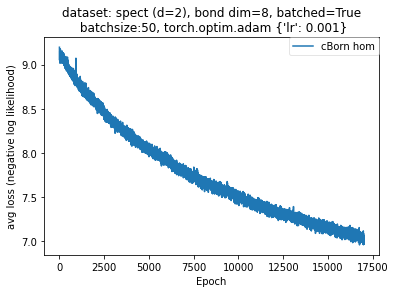

In [12]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 8
wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

# cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1)

lossvals = train_models([cBorn_s_hom],
    clamp_at=None, batchsize=50, max_epochs=17000, batched=True, optimizer=torch.optim.Adam, lr=1e-3)

╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Born (torch.complex64), Homogeneous, on cpu
│         batchsize:50, torch.optim.adam, {'lr': 0.01}.


├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([2, 8, 8])
│ loss values: 18.676 16.174 15.316 15.202 14.910 14.855 14.607 14.582 14.472 14.320 14.195 14.053 13.882 13.640 13.500 13.351 13.168 13.095 12.981 12.903 12.830 12.760 12.616 12.555 12.474 12.432 12.463 12.332 12.329 12.213 12.255 12.170 12.213 12.082 12.036 11.998 12.028 11.961 11.869 11.827 11.829 11.728 11.737 11.715 11.764 11.819 11.772 11.750 11.851 11.681 11.678 11.634 11.572 11.570 11.477 11.603 11.474 11.440 11.454 11.392 11.373 11.378 11.400 11.394 11.397 11.259 11.338 11.349 11.319 11.283 11.221 11.311 11.332 11.410 11.260 11.240 11.229 11.250 11.191 11.193 11.182 11.144 11.196 11.181 11.044 11.123 11.092 11.052 10.981 10.943 11.025 10.936 10.886 10.857 10.939 10.921 10.810 10.868 10.880 10.836 10.849 10.816 10.831 10.838 10.840 10.870 10.853 10.795 10.762 10.808 10.818 10.799 10.764 10.627 10.7

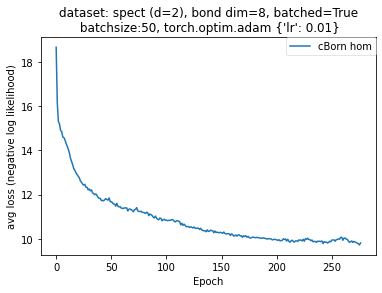

In [4]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 8
wr = 'gaussian_zeros' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

cBorn_s_hom2= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1)

lossvals = train_models([cBorn_s_hom2],
    clamp_at=None, batchsize=50, max_epochs=3000, batched=True, optimizer=torch.optim.Adam, lr=1e-2)

-----------------
# TESTING spect

In [17]:
import pandas as pd
# # c_lossvals1 = lossvals1.copy()
# # c_lossvals2 = lossvals2.copy()
# # c_lossvals4 = lossvals4.copy()
# # c_lossvals6 = lossvals6.copy()
# # c_lossvals8 = lossvals8.copy()
# # c_lossvals10 = lossvals10.copy()
for lvals in (lossvals_c1,lossvals_c2,lossvals_c4,lossvals_c6,lossvals_c8,lossvals_c10):
    print(pd.DataFrame(lvals).iloc[-1])
for lvals in (lossvals_c1,lossvals_c2,lossvals_c4,lossvals_c6,lossvals_c8,lossvals_c10):
    print(pd.DataFrame(lvals).iloc[-1][0])
for lvals in (lossvals_c1,lossvals_c2,lossvals_c4,lossvals_c6,lossvals_c8,lossvals_c10):
    print(pd.DataFrame(lvals).iloc[-1][1])

cBorn hom        12.426724
cBorn non-hom    11.162560
Name: 999, dtype: float64
cBorn hom        11.115941
cBorn non-hom     9.278877
Name: 999, dtype: float64
cBorn hom        9.784745
cBorn non-hom    7.627998
Name: 999, dtype: float64
cBorn hom        9.227400
cBorn non-hom    6.653184
Name: 999, dtype: float64
cBorn hom        8.643519
cBorn non-hom    6.021330
Name: 999, dtype: float64
cBorn hom        8.221741
cBorn non-hom    5.529493
Name: 999, dtype: float64
12.426724433898926
11.115941047668457
9.784745216369629
9.227399826049805
8.643519401550293
8.22174072265625
11.162559509277344
9.278877258300781
7.627997875213623
6.653184413909912
6.0213303565979
5.5294928550720215


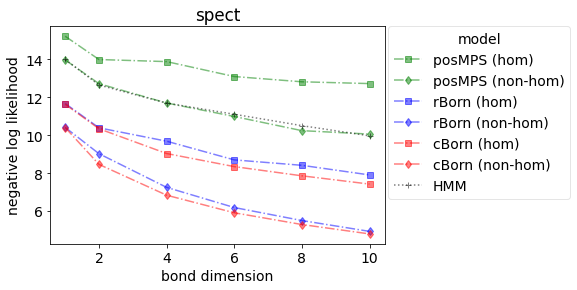

In [16]:
import pandas as pd
plt.rcParams.update({'font.size': 14}) # font.size change from default 10


f=plt.figure()
index = [1,2,4,6,8,10]
mps_h   = pd.Series([15.218861, 13.991366, 13.881930, 13.095338, 12.817768, 12.722956], index=index)
mps     = pd.Series([13.973183, 12.716292, 11.700251, 10.988507, 10.242457, 10.060400], index=index)
rborn_h = pd.Series([11.673271, 10.391518, 9.685891, 8.700957, 8.414715, 7.907423], index=index)
rborn   = pd.Series([10.412937, 9.026780, 7.251949, 6.190073, 5.503397, 4.932064], index=index)
cborn_h = pd.Series([11.631803, 10.342633, 9.035985, 8.346811, 7.861170, 7.425062], index=index)
cborn   = pd.Series([10.405153, 8.462505, 6.839746, 5.912520, 5.293955, 4.798422], index=index)
hmm     = pd.Series([13.993, 12.649, 11.695, 11.106, 10.505, 9.968], index=index)
plt.plot(mps_h,  "s-.", color="green", label="posMPS (hom)", alpha=0.5)
plt.plot(mps,    "d-.", color="green", label="posMPS (non-hom)", alpha=0.5)
plt.plot(rborn_h,"s-.", color="blue", label="rBorn (hom)", alpha=0.5)
plt.plot(rborn,  "d-.", color="blue", label="rBorn (non-hom)", alpha=0.5)
plt.plot(cborn_h,"s-.", color="red", label="cBorn (hom)", alpha=0.5)
plt.plot(cborn,  "d-.", color="red", label="cBorn (non-hom)", alpha=0.5)
plt.plot(hmm,    "+:k", color="black", label='HMM', alpha=0.5)
plt.legend(title="model", bbox_to_anchor=(1.01, 1), loc='upper left', framealpha=0.5, borderaxespad=0.)
plt.title("spect")
plt.ylabel('negative log likelihood')
plt.xlabel("bond dimension")
plt.show()
# f=plt.figure()
# f.savefig("spect.pdf", bbox_inches='tight')


In [7]:
import pandas as pd
index = [1,2,4,6,8,10]
df_spect = pd.DataFrame({
    1: pd.DataFrame(lossvals1).iloc[-1],
    2: pd.DataFrame(lossvals2).iloc[-1],
    4: pd.DataFrame(lossvals4).iloc[-1],
    6: pd.DataFrame(lossvals6).iloc[-1],
    8: pd.DataFrame(lossvals8).iloc[-1],
    10: pd.DataFrame(lossvals10).iloc[-1]
    })
# df_spect.plot(xlabel="bond dimension D", ylabel="loss (negative log likelihod)", marker='x')
hmm=pd.Series([13.993, 12.649, 11.695, 11.106, 10.505, 9.968], index=index)
plt.plot(df_spect.iloc[0], "s-.", color="C0", label="posMPS (hom)", alpha=0.7)
plt.plot(df_spect.iloc[1], "d-.", color="C0", label="posMPS (non-hom)", alpha=0.7)
plt.plot(df_spect.iloc[2], "s-.", color="C1", label="rBorn (hom)", alpha=0.7)
plt.plot(df_spect.iloc[3], "d-.", color="C1", label="rBorn (non-hom)", alpha=0.7)
plt.plot(df_spect.iloc[4], "s-.", color="C2", label="cBorn (hom)", alpha=0.7)
plt.plot(df_spect.iloc[5], "d-.", color="C2", label="cBorn (non-hom)", alpha=0.7)
plt.plot(hmm, "+:k", color="black", label='HMM', alpha=0.5)
plt.title("spect")
plt.ylabel('negative log likelihood')
plt.xlabel('bond dimension (hidden dimension for HMM)')
plt.legend(title="model", bbox_to_anchor=(1.01, 1), loc='upper left', framealpha=0.5, ncol=1, borderaxespad=0.)
plt.show()
df_spect.transpose()

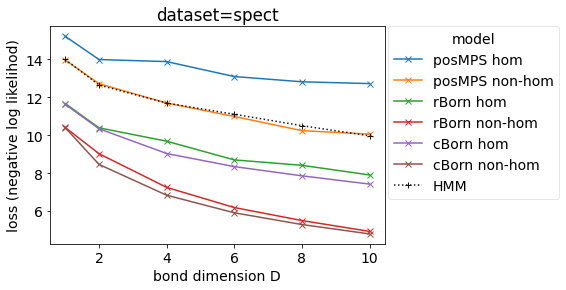

,1,2,4,6,8,10
posMPS hom,15.218861,13.991366,13.881930,13.095338,12.817768,12.722956
posMPS non-hom,13.973183,12.716292,11.700251,10.988507,10.242457,10.060400
rBorn hom,11.673271,10.391518,9.685891,8.700957,8.414715,7.907423
rBorn non-hom,10.412937,9.026780,7.251949,6.190073,5.503397,4.932064
cBorn hom,11.631803,10.342633,9.035985,8.346811,7.861170,7.425062
cBorn non-hom,10.405153,8.462505,6.839746,5.912520,5.293955,4.798422


In [108]:
import pandas as pd
plt.rcParams.update({'font.size': 14}) # font.size change from default 10
index = [1,2,4,6,8,10]
frame=pd.DataFrame()
frame['posMPS hom'] = pd.Series([15.218861, 13.991366, 13.881930, 13.095338, 12.817768, 12.722956], index=index)
frame['posMPS non-hom'] = pd.Series([13.973183, 12.716292, 11.700251, 10.988507, 10.242457, 10.060400], index=index)
frame['rBorn hom'] = pd.Series([11.673271, 10.391518, 9.685891, 8.700957, 8.414715, 7.907423], index=index)
frame['rBorn non-hom'] = pd.Series([10.412937, 9.026780, 7.251949, 6.190073, 5.503397, 4.932064], index=index)
frame['cBorn hom'] = pd.Series([11.631803, 10.342633, 9.035985, 8.346811, 7.861170, 7.425062], index=index)
frame['cBorn non-hom'] = pd.Series([10.405153, 8.462505, 6.839746, 5.912520, 5.293955, 4.798422], index=index)
frame.plot(
    xlabel="bond dimension D", ylabel="loss (negative log likelihod)", marker='x', title="dataset=spect")#, legend=None)
hmm=pd.Series([13.993, 12.649, 11.695, 11.106, 10.505, 9.968], index=index)
plt.plot(hmm, "+:k", label='HMM', alpha=0.9)
plt.legend(title="model", bbox_to_anchor=(1.01, 1), loc='upper left', framealpha=0.5, borderaxespad=0.)
plt.show()
frame.transpose()


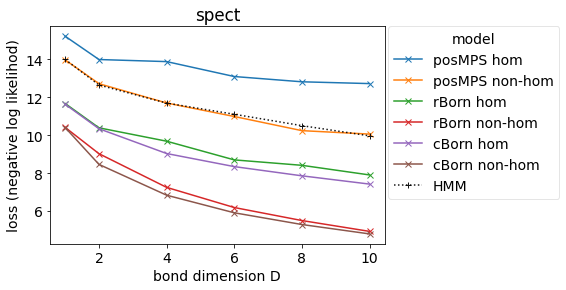

,1,2,4,6,8,10
posMPS hom,15.218861,13.991366,13.881930,13.095338,12.817768,12.722956
posMPS non-hom,13.973183,12.716292,11.700251,10.988507,10.242457,10.060400
rBorn hom,11.673271,10.391518,9.685891,8.700957,8.414715,7.907423
rBorn non-hom,10.412937,9.026780,7.251949,6.190073,5.503397,4.932064
cBorn hom,11.631803,10.342633,9.035985,8.346811,7.861170,7.425062
cBorn non-hom,10.405153,8.462505,6.839746,5.912520,5.293955,4.798422


In [115]:
import pandas as pd
index = [1,2,4,6,8,10]
df_spect = pd.DataFrame({
    1: pd.DataFrame(lossvals1).iloc[-1],
    2: pd.DataFrame(lossvals2).iloc[-1],
    4: pd.DataFrame(lossvals4).iloc[-1],
    6: pd.DataFrame(lossvals6).iloc[-1],
    8: pd.DataFrame(lossvals8).iloc[-1],
    10: pd.DataFrame(lossvals10).iloc[-1]
    }).transpose()
df_spect.plot(xlabel="bond dimension D", ylabel="loss (negative log likelihod)", marker='x')
hmm=pd.Series([13.993, 12.649, 11.695, 11.106, 10.505, 9.968], index=index)
plt.plot(hmm, "+:k", label='HMM', alpha=0.9)
plt.title("spect")
plt.legend(title="model", bbox_to_anchor=(1.01, 1), loc='upper left', framealpha=0.5, ncol=1, borderaxespad=0.)
plt.show()
df_spect.transpose()

-----------------

╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Positive MPS, Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 15.161 14.776 14.440 14.283 14.192 14.093 14.070 14.010 14.009 13.998 13.978 13.972 13.924 13.979 13.926 13.948 13.934 13.954 13.927 13.924 13.858 13.895 13.886 13.831 13.810 13.781 13.735 13.632 13.569 13.456 13.470 13.336 13.362 13.320 13.270 13.245 13.229 13.180 13.238 13.237 13.240 13.200 13.177 13.160 13.144 13.156 13.190 13.137 13.132 13.110 13.128 13.110 13.140 13.117 13.073 13.080 13.145 13.122 13.078 13.087 13.106 13.090 13.084 13.045 13.032 13.066 13.119 13.091 13.079 13.064 13.045 13.052 13.041 13.082 13.082 13.082 13.059 13.027 13.042 13.029 13.034 13.028 13.032 13.035 13.031 12.994 12.986 13.057 13.014 12.976 13.020 13.006 13.030 13.019 13.039 12.984 12.968 13.019 12.994 12.992 13.000 12.968 12.995 12.944 13.009 12.939 12.973 12.988 12.962 13.008 12.968 12.976 12.995 12.947 12.960 12.948 12.955 12.957 12.944 12.994 12.937 12.955 12.938 12.944 12.962 12.932 12.968 12.910 12.917 12.962 12.940 12.927 12.927 12.902 12.960 12.931 12.906 12.928 12.909 12.949 12.9


│ loss values: 15.201 14.202 13.930 13.768 13.675 13.580 13.500 13.413 13.391 13.387 13.372 13.317 13.367 13.346 13.316 13.303 13.320 13.281 13.286 13.323 13.247 13.237 13.269 13.271 13.280 13.221 13.234 13.237 13.228 13.202 13.215 13.213 13.172 13.141 13.157 13.160 13.146 13.129 13.069 13.026 12.967 12.919 12.870 12.832 12.791 12.736 12.729 12.691 12.615 12.615 12.574 12.522 12.463 12.423 12.379 12.281 12.267 12.235 12.177 12.140 12.050 12.048 12.009 11.977 11.930 11.936 11.890 11.877 11.819 11.802 11.792 11.792 11.735 11.701 11.689 11.686 11.686 11.659 11.634 11.633 11.597 11.620 11.605 11.569 11.560 11.540 11.552 11.531 11.503 11.509 11.474 11.463 11.472 11.424 11.412 11.415 11.413 11.374 11.385 11.311 11.329 11.269 11.278 11.246 11.221 11.197 11.178 11.155 11.141 11.164 11.100 11.107 11.066 11.049 11.062 10.991 10.997 10.988 11.025 10.954 10.925 10.942 10.913 10.885 10.898 10.891 10.869 10.875 10.887 10.843 10.868 10.827 10.817 10.819 10.817 10.810 10.825 10.756 10.771 10.788 10.7


│ loss values: 15.533 15.373 15.245 15.045 14.806 14.562 14.343 14.211 14.140 14.076 14.035 13.965 13.965 13.941 13.931 13.914 13.908 13.876 13.821 13.808 13.811 13.817 13.776 13.786 13.802 13.789 13.771 13.793 13.777 13.728 13.701 13.674 13.680 13.626 13.609 13.636 13.570 13.611 13.585 13.572 13.533 13.532 13.572 13.525 13.530 13.518 13.490 13.461 13.469 13.451 13.421 13.381 13.379 13.401 13.362 13.357 13.327 13.286 13.290 13.256 13.144 13.072 12.935 12.742 12.652 12.575 12.549 12.478 12.401 12.415 12.359 12.334 12.374 12.338 12.267 12.269 12.364 12.257 12.226 12.177 12.188 12.172 12.189 12.160 12.141 12.082 12.084 12.105 12.118 12.050 12.042 11.992 12.035 12.017 11.932 11.933 11.889 11.944 11.919 11.951 11.910 11.839 11.828 11.815 11.817 11.821 11.816 11.709 11.746 11.735 11.619 11.665 11.688 11.625 11.588 11.574 11.564 11.580 11.537 11.585 11.543 11.553 11.523 11.482 11.490 11.502 11.424 11.450 11.411 11.439 11.418 11.450 11.359 11.409 11.378 11.385 11.364 11.372 11.332 11.360 11.3


│ loss values: 15.477 14.591 14.428 14.314 14.199 14.082 14.058 13.877 13.846 13.756 13.745 13.650 13.646 13.639 13.572 13.538 13.509 13.485 13.470 13.418 13.419 13.421 13.365 13.310 13.369 13.285 13.320 13.299 13.238 13.226 13.227 13.206 13.274 13.185 13.207 13.186 13.141 13.123 13.095 13.077 13.066 13.089 13.036 13.036 13.029 13.053 13.037 12.979 12.994 12.987 12.941 12.921 12.956 12.917 12.910 12.898 12.901 12.855 12.886 12.861 12.850 12.833 12.797 12.802 12.809 12.783 12.759 12.766 12.766 12.726 12.749 12.750 12.707 12.722 12.749 12.655 12.688 12.651 12.608 12.633 12.630 12.621 12.634 12.589 12.573 12.576 12.586 12.552 12.511 12.526 12.480 12.520 12.472 12.518 12.448 12.444 12.442 12.396 12.375 12.365 12.337 12.323 12.296 12.244 12.195 12.149 12.116 12.039 11.993 11.939 11.928 11.959 11.927 11.818 11.758 11.722 11.630 11.606 11.516 11.496 11.497 11.495 11.420 11.438 11.368 11.332 11.242 11.278 11.246 11.218 11.199 11.137 11.090 11.096 11.034 10.958 10.968 10.904 10.881 10.855 10.8


│ loss values: 16.169 15.987 15.853 15.653 15.436 15.167 14.995 14.851 14.684 14.558 14.410 14.384 14.315 14.306 14.213 14.231 14.131 14.124 14.119 14.090 14.062 14.071 14.030 14.019 13.937 13.946 13.922 13.923 13.885 13.876 13.873 13.866 13.847 13.846 13.792 13.767 13.793 13.805 13.788 13.738 13.721 13.696 13.698 13.685 13.673 13.636 13.627 13.622 13.616 13.584 13.585 13.563 13.521 13.519 13.489 13.481 13.417 13.317 13.177 13.031 12.981 12.917 12.895 12.874 12.793 12.772 12.728 12.654 12.671 12.639 12.563 12.678 12.648 12.537 12.475 12.561 12.509 12.452 12.369 12.443 12.371 12.309 12.552 12.323 12.270 12.264 12.208 12.109 12.087 12.011 11.958 11.973 11.952 11.913 11.877 11.841 11.793 11.794 11.776 11.821 11.805 11.710 11.707 11.711 11.699 11.607 11.604 11.586 11.564 11.558 11.554 11.628 11.535 11.532 11.431 11.435 11.466 11.502 11.429 11.413 11.380 11.378 11.356 11.384 11.331 11.360 11.334 11.362 11.281 11.285 11.365 11.298 11.291 11.302 11.255 11.250 11.265 11.314 11.238 11.248 11.2


│ loss values: 15.576 14.725 14.609 14.455 14.345 14.240 14.160 14.049 13.994 13.900 13.843 13.832 13.791 13.730 13.693 13.667 13.638 13.647 13.638 13.607 13.576 13.559 13.528 13.489 13.497 13.486 13.431 13.415 13.393 13.359 13.357 13.338 13.363 13.298 13.319 13.239 13.291 13.230 13.236 13.183 13.190 13.209 13.177 13.162 13.117 13.148 13.132 13.092 13.065 13.070 13.045 13.038 12.999 13.023 12.999 12.957 12.943 12.959 12.924 12.883 12.849 12.847 12.808 12.812 12.785 12.726 12.660 12.661 12.554 12.424 12.346 12.212 12.114 12.008 11.926 11.854 11.839 11.769 11.696 11.673 11.637 11.624 11.563 11.533 11.522 11.492 11.405 11.412 11.333 11.269 11.210 11.141 11.107 10.985 10.979 10.921 10.899 10.849 10.785 10.739 10.669 10.651 10.630 10.562 10.541 10.465 10.434 10.424 10.357 10.345 10.291 10.251 10.268 10.210 10.172 10.149 10.090 10.070 10.033 9.965 9.961 9.883 9.849 9.860 9.813 9.803 9.771 9.742 9.714 9.695 9.643 9.584 9.571 9.567 9.540 9.519 9.441 9.429 9.460 9.373 9.346 9.384 9.307 9.326 9

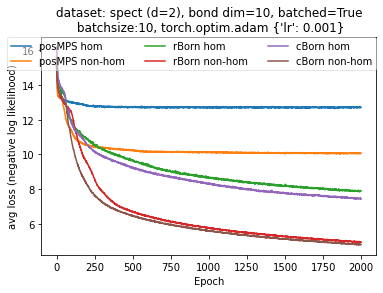

In [13]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 10

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals10 = train_models(
    [mps_s_hom, mps_s, rBorn_s_hom, rBorn_s, cBorn_s_hom, cBorn_s],
    clamp_at=None, batchsize=10, max_epochs=2000, batched=True, ncol=3, optimizer=torch.optim.Adam, lr=1e-3)


╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Positive MPS, Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 15.583 15.186 15.013 14.796 14.595 14.429 14.320 14.214 14.152 14.108 14.041 14.020 14.004 13.985 13.944 13.964 14.004 14.014 14.035 13.920 13.965 13.939 13.923 13.943 13.932 13.910 13.924 13.931 13.929 13.942 13.958 13.912 13.923 13.889 13.906 13.886 13.881 13.893 13.879 13.847 13.822 13.858 13.791 13.838 13.772 13.807 13.747 13.702 13.657 13.624 13.563 13.537 13.475 13.446 13.457 13.386 13.397 13.354 13.366 13.337 13.310 13.276 13.332 13.302 13.303 13.315 13.247 13.260 13.262 13.313 13.273 13.235 13.258 13.227 13.208 13.225 13.203 13.179 13.228 13.200 13.166 13.169 13.190 13.169 13.161 13.193 13.156 13.154 13.111 13.087 13.110 13.125 13.121 13.096 13.077 13.119 13.107 13.089 13.103 13.131 13.066 13.097 13.091 13.085 13.105 13.061 13.067 13.063 13.065 13.078 13.078 13.053 13.045 13.052 13.053 13.069 13.060 13.089 13.056 13.061 13.054 13.049 13.019 13.032 13.046 13.030 13.042 13.036 13.026 13.067 13.053 13.022 13.022 13.034 13.029 12.972 13.002 12.988 13.008 13.005 12.9


│ loss values: 15.184 14.245 13.912 13.823 13.699 13.620 13.545 13.501 13.472 13.387 13.365 13.353 13.356 13.358 13.319 13.281 13.306 13.278 13.296 13.271 13.278 13.269 13.281 13.275 13.243 13.255 13.252 13.261 13.212 13.237 13.230 13.203 13.229 13.237 13.183 13.197 13.188 13.203 13.149 13.151 13.132 13.088 13.065 13.035 13.040 13.009 12.989 12.961 12.925 12.890 12.870 12.859 12.778 12.793 12.702 12.678 12.613 12.482 12.490 12.427 12.415 12.341 12.294 12.284 12.262 12.187 12.129 12.134 12.123 12.075 12.067 12.030 12.032 12.040 12.019 11.973 11.978 11.984 11.935 11.951 11.936 11.921 11.880 11.875 11.863 11.878 11.864 11.838 11.805 11.829 11.774 11.790 11.770 11.767 11.748 11.727 11.711 11.748 11.638 11.742 11.692 11.670 11.641 11.596 11.630 11.612 11.568 11.615 11.589 11.552 11.552 11.557 11.513 11.518 11.506 11.462 11.484 11.467 11.443 11.414 11.406 11.404 11.372 11.379 11.350 11.380 11.327 11.337 11.304 11.292 11.283 11.280 11.251 11.272 11.232 11.247 11.232 11.215 11.206 11.233 11.1


│ loss values: 16.105 15.605 15.485 15.276 15.050 14.818 14.662 14.561 14.517 14.421 14.359 14.271 14.219 14.226 14.169 14.172 14.145 14.084 14.065 14.057 14.088 14.099 14.013 13.986 13.997 13.972 13.921 13.944 13.908 13.937 13.877 13.855 13.866 13.852 13.784 13.772 13.785 13.766 13.776 13.714 13.727 13.675 13.710 13.658 13.612 13.586 13.574 13.491 13.474 13.374 13.234 13.042 12.906 12.789 12.673 12.673 12.731 12.673 12.604 12.650 12.630 12.575 12.561 12.624 12.621 12.441 12.526 12.532 12.497 12.503 12.442 12.415 12.441 12.403 12.380 12.415 12.313 12.384 12.313 12.275 12.284 12.270 12.247 12.295 12.281 12.258 12.238 12.224 12.184 12.178 12.178 12.143 12.192 12.168 12.169 12.124 12.113 12.129 12.122 12.222 12.160 12.052 12.007 12.062 11.994 12.013 12.001 11.996 12.021 11.983 12.059 11.955 11.995 11.915 11.920 11.907 11.927 11.860 11.897 11.909 11.830 11.855 11.815 11.806 11.828 11.819 11.760 11.771 11.758 11.744 11.684 11.731 11.721 11.651 11.653 11.659 11.661 11.637 11.644 11.646 11.5


│ loss values: 15.440 14.573 14.306 14.250 14.181 14.068 13.994 13.933 13.843 13.818 13.712 13.615 13.557 13.516 13.490 13.506 13.475 13.405 13.416 13.360 13.354 13.328 13.286 13.302 13.294 13.281 13.242 13.198 13.210 13.217 13.167 13.191 13.136 13.127 13.137 13.088 13.104 13.069 13.051 13.037 13.026 13.039 13.005 12.963 12.966 12.981 12.942 12.923 12.889 12.895 12.882 12.912 12.878 12.878 12.801 12.862 12.837 12.785 12.799 12.781 12.777 12.746 12.746 12.755 12.718 12.700 12.713 12.696 12.699 12.643 12.622 12.678 12.611 12.633 12.621 12.557 12.574 12.539 12.578 12.567 12.567 12.552 12.505 12.521 12.525 12.520 12.496 12.454 12.481 12.463 12.422 12.440 12.431 12.396 12.379 12.395 12.345 12.362 12.330 12.308 12.289 12.258 12.245 12.245 12.169 12.215 12.117 12.157 12.104 12.014 12.000 11.962 11.919 11.870 11.829 11.793 11.695 11.637 11.593 11.570 11.519 11.499 11.435 11.443 11.380 11.290 11.285 11.228 11.134 11.127 11.074 11.002 10.994 11.003 10.929 10.902 10.902 10.866 10.841 10.834 10.8


│ loss values: 16.062 15.783 15.572 15.261 15.029 14.843 14.687 14.576 14.580 14.519 14.473 14.394 14.440 14.382 14.356 14.312 14.328 14.296 14.285 14.242 14.230 14.200 14.173 14.175 14.142 14.159 14.137 14.127 14.087 14.099 14.032 14.071 14.029 14.007 14.004 13.983 13.949 13.921 13.942 13.930 13.915 13.903 13.890 13.859 13.861 13.882 13.836 13.819 13.863 13.822 13.768 13.754 13.742 13.744 13.713 13.703 13.716 13.718 13.692 13.709 13.644 13.694 13.633 13.656 13.631 13.625 13.579 13.562 13.577 13.554 13.549 13.547 13.520 13.509 13.531 13.492 13.531 13.485 13.466 13.446 13.477 13.441 13.433 13.440 13.427 13.413 13.417 13.388 13.365 13.377 13.336 13.351 13.312 13.288 13.284 13.248 13.231 13.211 13.156 13.133 13.008 12.922 12.886 12.806 12.642 12.656 12.587 12.533 12.469 12.464 12.438 12.419 12.476 12.434 12.405 12.434 12.275 12.235 12.252 12.235 12.183 12.138 12.159 12.144 12.104 12.098 12.024 12.024 12.080 12.037 11.942 11.947 11.932 11.945 11.938 11.845 11.939 11.830 11.800 11.721 11.7


│ loss values: 15.589 14.562 14.329 14.279 14.143 14.071 13.961 13.870 13.831 13.747 13.647 13.609 13.540 13.529 13.492 13.476 13.467 13.392 13.424 13.385 13.310 13.312 13.271 13.258 13.249 13.227 13.245 13.213 13.187 13.171 13.186 13.123 13.147 13.114 13.046 13.075 13.054 13.026 13.027 13.041 13.010 13.006 12.982 12.951 13.001 12.923 12.923 12.894 12.864 12.905 12.850 12.865 12.838 12.799 12.801 12.797 12.788 12.756 12.763 12.724 12.746 12.743 12.678 12.649 12.658 12.620 12.551 12.540 12.527 12.433 12.410 12.403 12.342 12.306 12.253 12.233 12.218 12.144 12.069 11.950 11.850 11.802 11.764 11.650 11.589 11.553 11.469 11.427 11.352 11.306 11.247 11.224 11.160 11.131 11.078 11.033 11.076 11.015 10.992 10.902 10.899 10.866 10.795 10.835 10.771 10.694 10.710 10.718 10.623 10.665 10.562 10.520 10.466 10.452 10.418 10.358 10.390 10.317 10.312 10.234 10.208 10.237 10.183 10.154 10.084 10.092 10.093 10.015 10.028 9.986 9.975 9.935 9.868 9.877 9.840 9.792 9.796 9.761 9.764 9.733 9.707 9.657 9.6

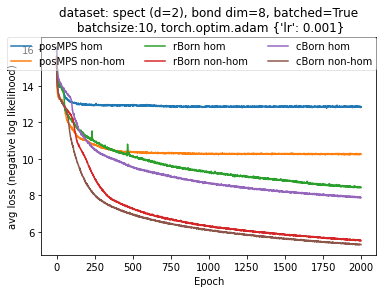

In [14]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 8

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals8 = train_models(
    [mps_s_hom, mps_s, rBorn_s_hom, rBorn_s, cBorn_s_hom, cBorn_s],
    clamp_at=None, batchsize=10, max_epochs=2000, batched=True, ncol=3, optimizer=torch.optim.Adam, lr=1e-3)


╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Positive MPS, Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 15.648 15.219 15.067 14.883 14.669 14.478 14.308 14.190 14.137 14.130 14.064 14.056 14.021 13.992 14.023 13.989 13.999 13.986 13.964 13.982 13.952 14.011 13.990 13.954 13.949 13.934 13.976 13.942 13.968 13.932 13.946 13.965 13.939 13.941 13.909 13.900 13.940 13.916 13.898 13.900 13.895 13.890 13.852 13.879 13.835 13.823 13.817 13.834 13.776 13.750 13.713 13.709 13.666 13.608 13.537 13.494 13.473 13.436 13.406 13.358 13.370 13.340 13.361 13.304 13.370 13.318 13.334 13.301 13.314 13.277 13.279 13.283 13.283 13.271 13.276 13.230 13.258 13.238 13.249 13.229 13.274 13.226 13.268 13.239 13.265 13.229 13.208 13.228 13.225 13.188 13.161 13.218 13.172 13.219 13.174 13.184 13.242 13.192 13.174 13.189 13.198 13.211 13.197 13.172 13.177 13.185 13.201 13.171 13.158 13.191 13.173 13.171 13.197 13.206 13.147 13.181 13.164 13.153 13.168 13.158 13.170 13.123 13.142 13.174 13.184 13.155 13.180 13.195 13.189 13.156 13.116 13.153 13.153 13.153 13.132 13.168 13.145 13.149 13.166 13.140 13.1


│ loss values: 15.239 14.353 13.983 13.819 13.728 13.650 13.581 13.494 13.507 13.466 13.463 13.423 13.390 13.388 13.359 13.367 13.327 13.265 13.298 13.293 13.290 13.289 13.255 13.295 13.246 13.245 13.227 13.188 13.210 13.196 13.195 13.192 13.152 13.154 13.128 13.104 13.105 13.052 13.048 13.000 12.945 12.903 12.886 12.869 12.836 12.786 12.778 12.727 12.703 12.712 12.649 12.629 12.561 12.556 12.550 12.493 12.475 12.428 12.408 12.389 12.355 12.334 12.327 12.299 12.296 12.306 12.267 12.262 12.243 12.263 12.217 12.191 12.236 12.190 12.169 12.213 12.155 12.183 12.169 12.107 12.129 12.115 12.120 12.134 12.139 12.094 12.099 12.076 12.089 12.094 12.053 12.053 12.055 12.006 12.018 12.052 12.049 11.996 11.990 11.967 12.026 11.972 11.978 11.954 11.949 11.934 11.933 11.965 11.933 11.935 11.934 11.887 11.919 11.905 11.921 11.898 11.900 11.869 11.878 11.908 11.903 11.860 11.855 11.893 11.868 11.854 11.878 11.853 11.890 11.851 11.867 11.817 11.834 11.826 11.816 11.855 11.814 11.810 11.790 11.801 11.7


│ loss values: 16.433 15.530 15.411 15.304 15.150 15.009 14.858 14.692 14.579 14.501 14.383 14.264 14.182 14.132 14.038 14.038 13.974 13.949 13.957 13.920 13.883 13.858 13.855 13.812 13.822 13.773 13.784 13.729 13.736 13.709 13.692 13.699 13.693 13.706 13.621 13.630 13.656 13.614 13.648 13.600 13.539 13.542 13.526 13.557 13.509 13.507 13.510 13.463 13.507 13.475 13.451 13.446 13.422 13.439 13.427 13.401 13.399 13.399 13.384 13.369 13.351 13.362 13.335 13.302 13.290 13.279 13.300 13.271 13.272 13.283 13.274 13.255 13.231 13.202 13.207 13.178 13.171 13.149 13.153 13.136 13.061 13.054 12.938 12.886 12.772 12.710 12.713 12.572 12.525 12.497 12.421 12.339 12.334 12.275 12.214 12.195 12.213 12.167 12.162 12.178 12.144 12.129 12.131 12.090 12.071 12.084 12.048 12.041 12.096 12.055 12.039 12.026 12.010 11.985 12.003 12.019 11.975 11.979 11.926 11.987 11.946 11.935 11.940 11.924 11.914 11.921 11.939 11.910 11.854 11.868 11.808 11.823 11.823 11.877 11.832 11.818 11.802 11.831 11.804 11.745 11.7


│ loss values: 15.435 14.613 14.371 14.236 14.161 14.062 13.963 13.911 13.832 13.762 13.715 13.621 13.578 13.541 13.492 13.482 13.409 13.384 13.384 13.339 13.313 13.343 13.283 13.303 13.271 13.228 13.231 13.227 13.182 13.157 13.166 13.136 13.142 13.099 13.101 13.066 13.059 13.061 13.027 13.013 12.995 13.004 12.984 12.963 12.955 12.925 12.923 12.925 12.934 12.903 12.903 12.863 12.843 12.846 12.841 12.816 12.825 12.826 12.799 12.782 12.761 12.765 12.751 12.724 12.693 12.710 12.691 12.701 12.681 12.684 12.661 12.688 12.630 12.623 12.627 12.635 12.614 12.590 12.631 12.598 12.589 12.556 12.570 12.542 12.528 12.536 12.519 12.524 12.533 12.487 12.464 12.497 12.468 12.441 12.428 12.421 12.463 12.438 12.398 12.395 12.414 12.361 12.354 12.346 12.305 12.294 12.312 12.289 12.257 12.230 12.260 12.226 12.188 12.161 12.156 12.144 12.093 12.070 12.024 11.995 11.966 11.943 11.885 11.846 11.811 11.794 11.748 11.689 11.695 11.607 11.551 11.458 11.450 11.350 11.331 11.304 11.284 11.223 11.162 11.192 11.1


│ loss values: 16.055 15.613 15.495 15.369 15.254 15.069 14.902 14.767 14.593 14.479 14.443 14.388 14.309 14.240 14.203 14.135 14.107 14.088 14.068 14.035 14.033 13.971 13.936 13.934 13.968 13.913 13.915 13.882 13.893 13.868 13.865 13.832 13.823 13.824 13.768 13.771 13.778 13.775 13.798 13.734 13.687 13.687 13.698 13.708 13.640 13.661 13.618 13.614 13.593 13.610 13.616 13.673 13.565 13.570 13.541 13.574 13.506 13.512 13.512 13.502 13.461 13.465 13.479 13.432 13.394 13.359 13.315 13.263 13.180 13.061 12.967 12.951 12.849 12.841 12.781 12.773 12.750 12.701 12.703 12.693 12.605 12.605 12.603 12.573 12.538 12.571 12.544 12.525 12.534 12.530 12.532 12.453 12.433 12.482 12.427 12.406 12.439 12.407 12.369 12.336 12.370 12.319 12.310 12.324 12.290 12.306 12.261 12.260 12.230 12.211 12.237 12.218 12.202 12.141 12.119 12.129 12.102 12.093 12.077 12.076 12.081 12.033 12.006 11.956 11.963 11.947 11.941 11.921 11.877 11.930 11.867 11.887 11.812 11.784 11.791 11.725 11.757 11.736 11.744 11.763 11.6


│ loss values: 15.950 14.947 14.586 14.441 14.349 14.252 14.145 14.104 14.030 13.946 13.845 13.790 13.761 13.708 13.684 13.624 13.587 13.560 13.519 13.497 13.461 13.437 13.441 13.397 13.364 13.348 13.364 13.320 13.324 13.289 13.272 13.270 13.306 13.225 13.193 13.202 13.184 13.134 13.153 13.147 13.149 13.123 13.068 13.105 13.049 13.022 13.043 13.021 13.000 13.003 12.977 12.962 12.965 12.915 12.950 12.935 12.944 12.890 12.882 12.876 12.849 12.829 12.863 12.809 12.813 12.743 12.752 12.757 12.767 12.707 12.708 12.710 12.693 12.693 12.654 12.631 12.607 12.619 12.608 12.593 12.537 12.565 12.535 12.484 12.504 12.433 12.431 12.371 12.425 12.311 12.307 12.216 12.168 12.111 11.966 11.892 11.839 11.799 11.689 11.627 11.579 11.509 11.521 11.412 11.379 11.341 11.314 11.250 11.283 11.252 11.213 11.145 11.155 11.076 11.042 11.075 11.041 11.021 10.977 10.952 10.896 10.953 10.899 10.877 10.800 10.790 10.771 10.771 10.729 10.740 10.689 10.662 10.621 10.582 10.599 10.556 10.534 10.496 10.462 10.481 10.4

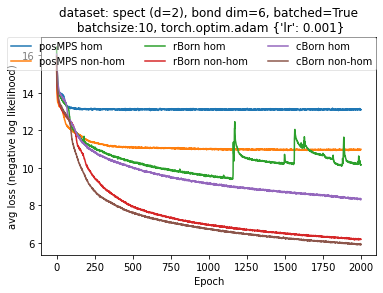

In [15]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 6

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals6 = train_models(
    [mps_s_hom, mps_s, rBorn_s_hom, rBorn_s, cBorn_s_hom, cBorn_s],
    clamp_at=None, batchsize=10, max_epochs=2000, batched=True, ncol=3, optimizer=torch.optim.Adam, lr=1e-3)


╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Positive MPS, Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 15.257 14.997 14.842 14.688 14.576 14.426 14.382 14.276 14.237 14.212 14.138 14.121 14.082 14.066 14.049 14.051 14.000 14.004 13.973 13.956 13.966 13.976 13.990 13.975 13.971 13.986 13.971 13.943 13.955 13.963 13.969 13.944 13.951 13.961 13.969 13.962 13.975 13.983 13.995 13.976 13.980 13.983 13.962 13.954 13.999 13.933 13.973 13.970 13.932 13.939 13.965 13.946 13.952 13.983 13.961 13.959 13.950 13.932 13.926 13.948 13.957 13.947 13.940 13.948 13.953 13.931 13.959 13.930 13.924 14.004 13.948 13.957 13.925 13.952 13.949 13.954 13.937 13.935 13.950 13.934 13.977 13.951 13.977 13.949 13.971 13.958 13.960 13.973 13.949 13.966 13.952 13.979 13.966 13.948 13.942 13.960 13.932 13.973 13.962 13.955 13.966 13.953 13.960 13.938 13.974 13.942 13.966 13.929 13.955 13.956 13.960 13.965 13.943 13.945 13.920 13.971 13.943 13.956 13.944 13.944 13.940 13.944 13.956 13.955 13.948 13.934 13.958 13.929 13.919 13.944 13.938 13.965 13.959 13.940 13.942 13.963 13.946 13.952 13.938 13.940 13.9


│ loss values: 16.321 15.237 14.628 14.239 14.028 13.903 13.776 13.696 13.664 13.561 13.518 13.501 13.432 13.406 13.384 13.355 13.348 13.325 13.284 13.275 13.268 13.277 13.293 13.265 13.270 13.260 13.235 13.249 13.229 13.239 13.217 13.236 13.229 13.222 13.212 13.182 13.248 13.184 13.193 13.189 13.152 13.177 13.159 13.151 13.152 13.119 13.083 13.071 13.037 13.026 12.994 12.997 12.928 12.924 12.922 12.943 12.941 12.885 12.879 12.880 12.860 12.860 12.859 12.845 12.815 12.857 12.822 12.818 12.784 12.813 12.772 12.731 12.754 12.771 12.751 12.729 12.687 12.695 12.714 12.676 12.643 12.657 12.636 12.599 12.645 12.628 12.626 12.609 12.578 12.548 12.506 12.501 12.507 12.500 12.509 12.493 12.460 12.446 12.448 12.397 12.400 12.409 12.368 12.363 12.363 12.331 12.350 12.316 12.337 12.333 12.324 12.320 12.302 12.285 12.306 12.260 12.243 12.274 12.230 12.247 12.250 12.220 12.216 12.206 12.201 12.165 12.176 12.187 12.141 12.163 12.146 12.090 12.139 12.100 12.121 12.079 12.060 12.090 12.046 12.073 12.0


│ loss values: 15.459 15.038 14.983 14.879 14.802 14.708 14.580 14.485 14.371 14.289 14.217 14.130 14.108 14.040 13.997 14.000 13.966 13.917 13.883 13.840 13.807 13.776 13.739 13.709 13.683 13.656 13.677 13.652 13.596 13.601 13.589 13.585 13.549 13.554 13.541 13.501 13.507 13.509 13.490 13.489 13.443 13.422 13.416 13.437 13.430 13.386 13.405 13.395 13.349 13.385 13.376 13.352 13.348 13.356 13.328 13.304 13.324 13.276 13.290 13.279 13.269 13.252 13.248 13.271 13.244 13.249 13.212 13.232 13.177 13.166 13.161 13.164 13.156 13.153 13.173 13.162 13.173 13.149 13.112 13.134 13.123 13.102 13.084 13.105 13.067 13.065 13.067 13.052 13.049 13.072 13.074 13.044 13.098 13.029 13.050 13.024 13.020 13.011 13.016 12.975 12.994 12.938 12.968 12.960 12.969 12.958 12.965 12.923 12.941 12.920 12.927 12.918 12.926 12.870 12.915 12.899 12.901 12.868 12.892 12.858 12.854 12.875 12.851 12.828 12.848 12.860 12.830 12.854 12.839 12.848 12.824 12.813 12.795 12.816 12.776 12.783 12.782 12.800 12.782 12.772 12.7


│ loss values: 16.101 15.043 14.502 14.199 14.064 13.943 13.878 13.797 13.763 13.707 13.661 13.633 13.552 13.537 13.481 13.441 13.386 13.373 13.293 13.290 13.241 13.196 13.167 13.115 13.090 13.067 13.076 13.028 13.047 13.031 13.010 12.957 12.929 12.935 12.912 12.891 12.907 12.893 12.841 12.861 12.816 12.811 12.838 12.800 12.797 12.794 12.780 12.758 12.741 12.737 12.708 12.696 12.697 12.661 12.681 12.692 12.670 12.665 12.625 12.634 12.600 12.609 12.611 12.581 12.560 12.600 12.579 12.592 12.548 12.557 12.532 12.551 12.509 12.493 12.523 12.501 12.490 12.460 12.472 12.486 12.467 12.420 12.440 12.441 12.420 12.421 12.402 12.402 12.385 12.360 12.379 12.375 12.384 12.343 12.364 12.332 12.356 12.310 12.291 12.310 12.289 12.312 12.270 12.296 12.285 12.265 12.258 12.248 12.238 12.250 12.219 12.219 12.209 12.221 12.246 12.222 12.180 12.232 12.201 12.219 12.168 12.176 12.156 12.141 12.155 12.136 12.148 12.150 12.113 12.093 12.116 12.121 12.065 12.085 12.094 12.114 12.063 12.060 12.056 12.030 12.0


│ loss values: 15.797 15.434 15.330 15.151 15.013 14.915 14.779 14.676 14.600 14.564 14.449 14.393 14.368 14.308 14.281 14.248 14.178 14.112 14.077 14.062 13.993 13.973 13.916 13.879 13.884 13.856 13.854 13.825 13.834 13.819 13.763 13.766 13.754 13.741 13.718 13.706 13.690 13.703 13.684 13.636 13.639 13.615 13.606 13.609 13.592 13.568 13.591 13.552 13.587 13.563 13.548 13.530 13.517 13.521 13.469 13.511 13.497 13.483 13.453 13.453 13.448 13.471 13.424 13.452 13.409 13.404 13.408 13.373 13.359 13.372 13.388 13.336 13.385 13.324 13.334 13.340 13.309 13.330 13.325 13.297 13.292 13.294 13.274 13.276 13.262 13.236 13.250 13.231 13.243 13.223 13.219 13.248 13.229 13.164 13.199 13.157 13.189 13.168 13.155 13.144 13.128 13.121 13.169 13.139 13.155 13.125 13.113 13.141 13.094 13.075 13.075 13.093 13.066 13.066 13.054 13.070 13.073 13.033 13.051 13.018 13.027 13.020 12.985 13.038 13.001 13.034 12.983 13.014 12.993 12.977 13.001 12.970 12.966 12.951 12.939 12.945 12.932 12.945 12.931 12.927 12.9


│ loss values: 15.958 14.983 14.508 14.307 14.154 14.101 13.997 13.926 13.877 13.810 13.745 13.718 13.670 13.629 13.571 13.515 13.482 13.425 13.381 13.375 13.295 13.285 13.259 13.249 13.225 13.228 13.180 13.138 13.133 13.133 13.101 13.107 13.059 13.083 13.050 13.035 13.008 13.003 12.988 12.980 12.937 12.927 12.939 12.911 12.881 12.903 12.852 12.850 12.822 12.874 12.813 12.806 12.828 12.779 12.763 12.782 12.758 12.744 12.733 12.713 12.711 12.723 12.696 12.662 12.711 12.646 12.657 12.628 12.625 12.613 12.624 12.594 12.587 12.566 12.573 12.557 12.573 12.519 12.542 12.517 12.514 12.495 12.500 12.479 12.470 12.425 12.438 12.434 12.436 12.419 12.443 12.396 12.440 12.377 12.369 12.374 12.379 12.375 12.315 12.312 12.319 12.290 12.301 12.304 12.239 12.275 12.209 12.173 12.192 12.172 12.149 12.140 12.119 12.090 12.085 12.056 12.049 12.021 12.041 11.958 11.925 11.969 11.906 11.905 11.881 11.847 11.845 11.824 11.816 11.787 11.752 11.740 11.736 11.741 11.668 11.700 11.665 11.682 11.610 11.598 11.6

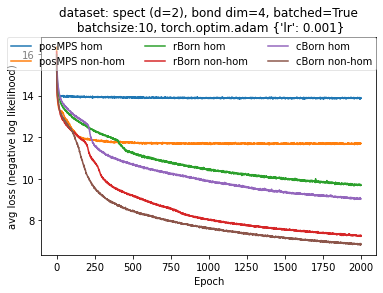

In [16]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 4

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals4 = train_models(
    [mps_s_hom, mps_s, rBorn_s_hom, rBorn_s, cBorn_s_hom, cBorn_s],
    clamp_at=None, batchsize=10, max_epochs=2000, batched=True, ncol=3, optimizer=torch.optim.Adam, lr=1e-3)

╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Positive MPS, Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 17.213 16.641 16.236 15.936 15.714 15.570 15.436 15.345 15.282 15.222 15.193 15.158 15.104 15.096 15.058 15.015 14.984 14.979 14.899 14.861 14.845 14.773 14.726 14.660 14.602 14.576 14.545 14.470 14.429 14.414 14.390 14.340 14.280 14.287 14.239 14.213 14.242 14.201 14.209 14.194 14.198 14.175 14.178 14.152 14.144 14.141 14.143 14.098 14.100 14.089 14.074 14.080 14.098 14.098 14.061 14.067 14.065 14.035 14.054 14.029 14.015 14.061 14.020 14.040 14.028 14.047 14.039 14.024 14.034 14.013 13.998 14.017 13.987 14.013 14.022 14.034 14.031 13.993 14.015 13.972 13.992 14.021 13.970 13.972 13.994 14.008 13.972 13.975 13.980 13.974 13.993 13.968 13.974 13.955 13.973 13.983 13.947 13.971 13.981 13.950 13.938 13.976 13.947 14.014 13.974 13.959 13.990 13.980 13.942 13.974 13.983 13.994 13.989 13.975 13.977 13.990 13.967 14.008 13.959 13.987 13.988 13.987 13.965 13.976 13.985 13.979 13.984 13.983 13.954 13.996 13.969 13.944 13.977 13.969 13.983 13.991 13.971 13.973 13.945 13.964 13.9


│ loss values: 15.678 15.116 14.752 14.476 14.298 14.144 14.035 14.003 13.909 13.845 13.814 13.803 13.743 13.747 13.711 13.691 13.662 13.625 13.650 13.615 13.620 13.597 13.579 13.554 13.514 13.537 13.525 13.516 13.481 13.481 13.468 13.457 13.437 13.444 13.458 13.412 13.410 13.394 13.423 13.418 13.383 13.369 13.374 13.383 13.397 13.337 13.385 13.389 13.374 13.359 13.384 13.360 13.363 13.341 13.372 13.348 13.338 13.344 13.324 13.362 13.345 13.342 13.357 13.349 13.370 13.340 13.367 13.345 13.342 13.330 13.324 13.360 13.334 13.355 13.334 13.343 13.328 13.340 13.285 13.311 13.300 13.290 13.312 13.312 13.310 13.294 13.331 13.306 13.342 13.324 13.329 13.307 13.326 13.304 13.344 13.310 13.329 13.329 13.299 13.295 13.270 13.322 13.298 13.300 13.309 13.302 13.292 13.262 13.328 13.308 13.286 13.312 13.310 13.273 13.294 13.297 13.291 13.251 13.280 13.302 13.292 13.262 13.280 13.307 13.300 13.281 13.279 13.288 13.274 13.303 13.279 13.317 13.276 13.300 13.266 13.267 13.282 13.296 13.302 13.296 13.2


│ loss values: 16.312 15.719 15.387 15.192 15.039 14.900 14.778 14.677 14.535 14.423 14.295 14.188 14.127 14.040 14.019 13.970 13.943 13.900 13.864 13.860 13.817 13.841 13.804 13.767 13.769 13.742 13.781 13.756 13.759 13.725 13.677 13.715 13.697 13.642 13.666 13.672 13.637 13.625 13.608 13.618 13.603 13.558 13.569 13.586 13.549 13.534 13.554 13.533 13.521 13.482 13.477 13.469 13.514 13.491 13.479 13.468 13.438 13.453 13.424 13.438 13.406 13.418 13.404 13.411 13.371 13.376 13.375 13.374 13.354 13.336 13.368 13.334 13.331 13.339 13.307 13.319 13.296 13.310 13.311 13.265 13.237 13.303 13.269 13.269 13.257 13.267 13.222 13.238 13.195 13.217 13.192 13.203 13.200 13.183 13.196 13.191 13.188 13.172 13.156 13.149 13.142 13.148 13.146 13.127 13.098 13.118 13.120 13.115 13.140 13.091 13.132 13.049 13.059 13.086 13.070 13.063 13.033 13.053 13.085 13.053 13.007 13.031 13.011 13.016 13.025 13.001 13.017 12.987 12.999 12.994 12.974 12.998 12.977 12.959 12.986 12.962 12.955 12.952 12.958 12.971 12.9


│ loss values: 16.532 15.675 15.058 14.584 14.257 14.073 13.907 13.756 13.642 13.577 13.491 13.434 13.405 13.386 13.332 13.357 13.315 13.272 13.237 13.235 13.222 13.203 13.197 13.150 13.156 13.143 13.105 13.117 13.069 13.065 13.035 13.034 13.006 12.975 13.002 13.007 12.971 12.925 12.938 12.929 12.943 12.885 12.888 12.875 12.858 12.869 12.859 12.837 12.807 12.790 12.807 12.802 12.762 12.727 12.725 12.734 12.698 12.688 12.655 12.669 12.667 12.651 12.624 12.629 12.635 12.597 12.579 12.564 12.536 12.539 12.526 12.500 12.495 12.487 12.489 12.470 12.469 12.407 12.426 12.417 12.466 12.406 12.400 12.416 12.413 12.400 12.377 12.370 12.387 12.375 12.373 12.346 12.331 12.375 12.336 12.327 12.296 12.288 12.300 12.287 12.295 12.248 12.255 12.258 12.266 12.221 12.246 12.211 12.221 12.192 12.215 12.209 12.226 12.200 12.181 12.174 12.167 12.166 12.143 12.201 12.175 12.116 12.110 12.089 12.115 12.116 12.119 12.066 12.101 12.095 12.071 12.079 12.061 12.059 12.097 12.073 11.994 12.035 12.039 12.025 12.0


│ loss values: 21.823 19.825 18.317 17.223 16.469 15.978 15.634 15.449 15.294 15.239 15.156 15.106 15.047 15.041 14.984 14.971 14.934 14.908 14.868 14.860 14.811 14.791 14.787 14.756 14.675 14.637 14.546 14.506 14.499 14.436 14.392 14.391 14.353 14.323 14.291 14.246 14.252 14.239 14.201 14.173 14.151 14.160 14.123 14.121 14.089 14.057 14.060 14.026 13.987 13.988 13.975 13.978 13.937 13.914 13.919 13.902 13.875 13.884 13.863 13.823 13.817 13.800 13.763 13.740 13.756 13.706 13.715 13.697 13.671 13.640 13.653 13.633 13.615 13.577 13.594 13.568 13.516 13.549 13.517 13.505 13.481 13.476 13.438 13.456 13.409 13.412 13.366 13.382 13.364 13.331 13.313 13.305 13.284 13.252 13.282 13.267 13.244 13.226 13.189 13.206 13.174 13.141 13.155 13.139 13.134 13.105 13.133 13.098 13.088 13.081 13.064 13.055 13.058 13.061 13.041 13.021 12.986 13.014 12.968 13.005 12.972 12.977 12.986 12.968 12.933 12.970 12.971 12.975 12.949 12.907 12.928 12.879 12.909 12.908 12.898 12.903 12.884 12.886 12.880 12.899 12.8


│ loss values: 16.381 15.731 15.268 14.901 14.631 14.417 14.285 14.122 14.066 13.985 13.913 13.828 13.755 13.693 13.696 13.667 13.620 13.567 13.513 13.495 13.455 13.422 13.405 13.398 13.314 13.316 13.284 13.290 13.229 13.223 13.195 13.178 13.178 13.115 13.106 13.090 13.070 13.097 13.016 13.059 13.021 13.013 12.994 12.966 12.984 12.941 12.914 12.911 12.914 12.921 12.856 12.861 12.839 12.800 12.789 12.783 12.796 12.824 12.765 12.748 12.752 12.727 12.758 12.719 12.737 12.691 12.675 12.648 12.633 12.679 12.631 12.633 12.598 12.624 12.603 12.626 12.570 12.580 12.591 12.566 12.571 12.558 12.571 12.540 12.508 12.550 12.483 12.525 12.499 12.477 12.483 12.422 12.473 12.445 12.457 12.456 12.426 12.447 12.435 12.409 12.370 12.410 12.382 12.380 12.369 12.343 12.384 12.377 12.352 12.324 12.340 12.327 12.288 12.337 12.308 12.306 12.329 12.279 12.277 12.267 12.262 12.270 12.250 12.214 12.258 12.252 12.246 12.207 12.242 12.236 12.210 12.212 12.189 12.201 12.219 12.183 12.173 12.207 12.185 12.148 12.1

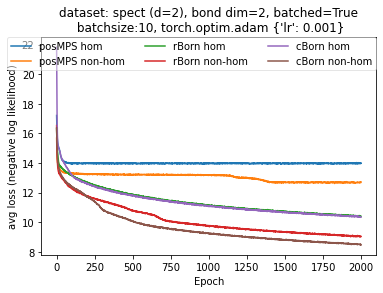

In [17]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 2

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals2 = train_models(
    [mps_s_hom, mps_s, rBorn_s_hom, rBorn_s, cBorn_s_hom, cBorn_s],
    clamp_at=None, batchsize=10, max_epochs=2000, batched=True, ncol=3, optimizer=torch.optim.Adam, lr=1e-3)


╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
dataset: spect
╭───────────────────────────batched=True
│Training Positive MPS, Homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.001}.



│ loss values: 15.362 15.298 15.288 15.265 15.251 15.221 15.222 15.194 15.210 15.233 15.226 15.218 15.201 15.224 15.237 15.244 15.227 15.247 15.220 15.207 15.221 15.201 15.210 15.222 15.206 15.195 15.248 15.195 15.233 15.212 15.224 15.230 15.195 15.217 15.217 15.212 15.224 15.218 15.222 15.231 15.208 15.237 15.206 15.207 15.224 15.219 15.207 15.266 15.218 15.205 15.219 15.204 15.223 15.240 15.234 15.221 15.234 15.224 15.225 15.231 15.253 15.195 15.237 15.242 15.217 15.225 15.222 15.222 15.261 15.212 15.210 15.200 15.222 15.221 15.236 15.249 15.231 15.212 15.230 15.244 15.183 15.226 15.222 15.223 15.229 15.221 15.237 15.201 15.209 15.248 15.204 15.206 15.220 15.197 15.229 15.215 15.241 15.212 15.209 15.233 15.212 15.212 15.219 15.219 15.210 15.230 15.229 15.230 15.186 15.234 15.201 15.228 15.191 15.221 15.231 15.250 15.229 15.215 15.223 15.234 15.218 15.241 15.222 15.202 15.215 15.231 15.203 15.201 15.216 15.238 15.223 15.251 15.227 15.238 15.206 15.197 15.199 15.218 15.205 15.214 15.2


│ loss values: 27.345 25.829 24.561 23.448 22.507 21.656 20.932 20.233 19.617 19.062 18.541 18.073 17.601 17.230 16.872 16.529 16.208 15.918 15.679 15.435 15.247 15.043 14.910 14.732 14.627 14.534 14.421 14.364 14.279 14.255 14.210 14.165 14.129 14.119 14.077 14.081 14.052 14.059 14.035 14.025 14.070 14.035 14.038 14.016 14.007 14.004 14.032 14.012 14.006 13.982 13.992 13.998 14.035 14.001 14.013 14.021 14.011 14.028 13.976 13.992 14.035 14.018 14.004 13.987 14.005 13.980 14.001 14.025 14.000 14.002 13.993 14.014 14.003 14.025 14.010 13.988 13.990 14.007 13.973 13.998 14.030 13.996 13.991 14.009 14.021 14.004 14.037 14.018 13.990 14.011 14.028 14.029 14.044 14.026 14.013 14.025 14.007 14.019 14.005 13.984 14.009 14.003 13.977 14.013 13.995 14.001 14.018 14.022 13.983 13.998 14.045 14.027 13.979 14.026 14.029 14.002 13.994 14.005 13.999 13.953 13.998 13.997 13.995 14.013 13.971 14.018 13.997 14.010 13.983 13.971 13.990 13.994 14.021 14.000 14.008 14.018 13.997 13.991 13.988 13.998 13.9


│ loss values: 18.589 17.831 17.212 16.705 16.271 15.946 15.679 15.468 15.300 15.195 15.083 15.048 14.962 14.938 14.945 14.895 14.880 14.834 14.843 14.841 14.839 14.820 14.792 14.778 14.759 14.739 14.745 14.760 14.693 14.706 14.699 14.702 14.697 14.704 14.664 14.657 14.631 14.635 14.638 14.607 14.608 14.603 14.610 14.576 14.597 14.580 14.548 14.572 14.529 14.560 14.511 14.519 14.523 14.505 14.487 14.473 14.504 14.488 14.462 14.472 14.469 14.449 14.457 14.427 14.426 14.415 14.428 14.424 14.423 14.390 14.382 14.387 14.371 14.377 14.365 14.375 14.374 14.336 14.377 14.333 14.317 14.336 14.338 14.305 14.318 14.302 14.295 14.291 14.302 14.279 14.259 14.265 14.274 14.257 14.252 14.261 14.259 14.239 14.227 14.233 14.222 14.200 14.193 14.194 14.198 14.208 14.196 14.205 14.172 14.199 14.149 14.175 14.180 14.147 14.141 14.156 14.123 14.130 14.163 14.132 14.117 14.120 14.143 14.120 14.110 14.088 14.076 14.093 14.085 14.104 14.073 14.080 14.092 14.056 14.058 14.035 14.056 14.024 14.065 14.052 14.0


│ loss values: 22.573 21.567 20.700 19.967 19.330 18.759 18.267 17.785 17.365 17.013 16.669 16.380 16.126 15.862 15.629 15.425 15.236 15.053 14.894 14.752 14.615 14.462 14.360 14.249 14.188 14.085 13.998 13.921 13.835 13.783 13.690 13.662 13.590 13.544 13.479 13.462 13.421 13.391 13.364 13.351 13.314 13.312 13.267 13.244 13.235 13.231 13.219 13.222 13.170 13.198 13.194 13.179 13.184 13.178 13.111 13.135 13.099 13.114 13.144 13.120 13.120 13.121 13.094 13.062 13.066 13.063 13.053 13.063 13.052 13.070 13.038 13.038 13.027 13.058 13.013 12.994 13.056 13.005 12.980 12.969 13.002 13.002 12.964 12.969 12.953 12.967 12.909 12.951 12.931 12.922 12.943 12.915 12.888 12.906 12.935 12.918 12.935 12.910 12.896 12.897 12.895 12.866 12.861 12.882 12.861 12.853 12.881 12.847 12.858 12.846 12.869 12.835 12.826 12.831 12.836 12.847 12.817 12.837 12.802 12.821 12.781 12.823 12.793 12.808 12.779 12.790 12.741 12.811 12.738 12.730 12.793 12.713 12.733 12.736 12.739 12.733 12.707 12.712 12.722 12.703 12.7


│ loss values: 15.036 14.941 14.910 14.887 14.895 14.878 14.853 14.802 14.816 14.799 14.788 14.775 14.762 14.790 14.783 14.727 14.755 14.728 14.717 14.711 14.690 14.664 14.684 14.662 14.644 14.676 14.644 14.636 14.627 14.614 14.611 14.634 14.596 14.585 14.573 14.555 14.548 14.524 14.515 14.522 14.538 14.513 14.497 14.472 14.511 14.487 14.468 14.451 14.470 14.434 14.416 14.414 14.438 14.448 14.437 14.395 14.405 14.424 14.407 14.388 14.364 14.383 14.347 14.334 14.351 14.344 14.339 14.335 14.308 14.301 14.328 14.300 14.311 14.263 14.282 14.276 14.282 14.284 14.264 14.280 14.249 14.236 14.233 14.243 14.238 14.202 14.219 14.204 14.226 14.198 14.197 14.180 14.197 14.176 14.161 14.198 14.186 14.159 14.154 14.146 14.170 14.136 14.150 14.135 14.149 14.112 14.135 14.133 14.100 14.100 14.121 14.101 14.106 14.107 14.079 14.069 14.095 14.057 14.078 14.050 14.049 14.053 14.048 14.033 14.037 14.038 14.020 14.004 14.010 14.021 14.016 13.994 14.006 13.989 14.002 13.981 14.000 13.990 13.975 13.973 13.9


│ loss values: 16.735 16.370 16.036 15.751 15.494 15.255 15.044 14.855 14.698 14.520 14.389 14.251 14.160 14.072 13.956 13.900 13.824 13.766 13.689 13.647 13.602 13.548 13.537 13.492 13.472 13.410 13.453 13.368 13.354 13.361 13.329 13.324 13.307 13.270 13.286 13.234 13.245 13.212 13.242 13.248 13.218 13.256 13.219 13.207 13.149 13.161 13.204 13.157 13.168 13.167 13.142 13.164 13.122 13.176 13.112 13.135 13.121 13.080 13.090 13.085 13.087 13.089 13.057 13.048 13.039 13.062 13.045 13.024 13.015 13.012 13.008 12.995 12.978 12.975 12.973 12.991 12.998 12.959 13.004 12.967 12.953 12.941 12.951 12.978 12.947 12.930 12.917 12.920 12.940 12.905 12.921 12.921 12.902 12.873 12.909 12.896 12.900 12.845 12.843 12.866 12.865 12.862 12.805 12.839 12.833 12.851 12.817 12.829 12.813 12.800 12.811 12.790 12.795 12.800 12.786 12.805 12.762 12.777 12.774 12.778 12.757 12.737 12.753 12.764 12.724 12.738 12.766 12.730 12.752 12.749 12.749 12.735 12.728 12.722 12.714 12.692 12.687 12.696 12.686 12.700 12.7

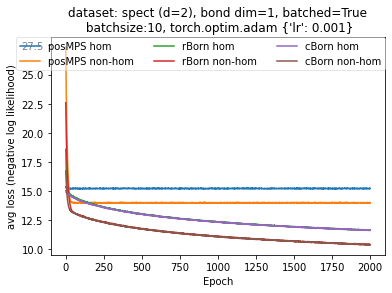

In [18]:
dataset = 'spect'
X,d = load_dataset(dataset)
D = 1

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals1 = train_models(
    [mps_s_hom, mps_s, rBorn_s_hom, rBorn_s, cBorn_s_hom, cBorn_s],
    clamp_at=None, batchsize=10, max_epochs=2000, batched=True, ncol=3, optimizer=torch.optim.Adam, lr=1e-3)

--------------------------------

## Playground

╭──tumor
│ data shape:(339, 17)
│ range of X values: 0 -- 3
╰───────────────────
dataset: tumor
╭───────────────────────────batched=True
│Training Positive MPS, Non-homogeneous + log_stability, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 1e-05}.



│ loss values: 23.728 23.573 23.419 23.266 23.115 22.965 22.816 22.669 22.523 22.378 22.235 22.093 21.953 21.814 21.675 21.539 21.403 21.269 21.135 21.004 20.874 20.744 20.616 20.488 20.361 20.237 20.113 19.991 19.868 19.749 19.629 19.511 19.394 19.279 19.164 19.052 18.938 18.825 18.717 18.607 18.499 18.391 18.284 18.180 18.075 17.973 17.871 17.769 17.671 17.571 17.471 17.375 17.279 17.185 17.088 16.996 16.903 16.811 16.719 16.630 16.540 16.454 16.366 16.282 16.195 16.110 16.029 15.946 15.866 15.782 15.701 15.624 15.543 15.467 15.391 15.316 15.238 15.166 15.091 15.019 14.947 14.879 14.806 14.738 14.667 14.600 14.533 14.464 14.397 14.334 14.271 14.208 14.144 14.082 14.018 13.960 13.898 13.840 13.783 13.724 13.665 13.607 13.554 13.499 13.443 13.388 13.335 13.285 13.230 13.179 13.128 13.081 13.030 12.978 12.932 12.884 12.832 12.787 12.741 12.696 12.651 12.611 12.561 12.518 12.476 12.435 12.393 12.351 12.307 12.268 12.229 12.195 12.152 12.113 12.077 12.042 12.004 11.965 11.934 11.891 11.8


│ loss values: 23.513 23.372 23.230 23.091 22.953 22.817 22.681 22.548 22.416 22.285 22.155 22.028 21.900 21.775 21.652 21.529 21.408 21.287 21.170 21.052 20.936 20.821 20.707 20.596 20.484 20.376 20.266 20.159 20.054 19.951 19.846 19.743 19.643 19.545 19.445 19.347 19.251 19.156 19.063 18.969 18.877 18.785 18.695 18.610 18.522 18.435 18.350 18.265 18.184 18.101 18.020 17.939 17.862 17.783 17.707 17.631 17.558 17.482 17.408 17.338 17.265 17.198 17.125 17.060 16.992 16.927 16.857 16.798 16.731 16.669 16.610 16.548 16.489 16.427 16.368 16.313 16.257 16.205 16.147 16.090 16.039 15.984 15.935 15.888 15.837 15.781 15.736 15.689 15.640 15.594 15.549 15.502 15.459 15.417 15.370 15.329 15.290 15.245 15.204 15.167 15.132 15.088 15.055 15.015 14.979 14.947 14.912 14.876 14.843 14.807 14.778 14.745 14.711 14.680 14.652 14.620 14.592 14.564 14.534 14.505 14.480 14.448 14.427 14.398 14.377 14.351 14.326 14.303 14.277 14.257 14.232 14.211 14.189 14.166 14.148 14.130 14.109 14.087 14.070 14.053 14.0


│ loss values: 23.643 23.455 23.268 23.085 22.902 22.723 22.545 22.369 22.194 22.023 21.852 21.684 21.518 21.353 21.191 21.028 20.869 20.711 20.556 20.402 20.250 20.099 19.950 19.802 19.655 19.511 19.368 19.226 19.087 18.949 18.811 18.677 18.542 18.410 18.277 18.149 18.020 17.893 17.768 17.644 17.523 17.401 17.281 17.163 17.045 16.928 16.815 16.702 16.588 16.481 16.370 16.262 16.155 16.050 15.943 15.842 15.741 15.639 15.540 15.440 15.345 15.248 15.156 15.059 14.968 14.874 14.785 14.695 14.608 14.521 14.436 14.349 14.267 14.185 14.104 14.023 13.942 13.867 13.788 13.711 13.635 13.563 13.489 13.417 13.345 13.277 13.204 13.136 13.070 13.004 12.938 12.872 12.810 12.746 12.684 12.623 12.562 12.504 12.446 12.389 12.334 12.275 12.223 12.167 12.114 12.062 12.008 11.960 11.912 11.861 11.814 11.764 11.719 11.671 11.627 11.581 11.535 11.493 11.450 11.408 11.371 11.330 11.292 11.249 11.215 11.174 11.136 11.104 11.065 11.029 10.996 10.961 10.926 10.891 10.864 10.829 10.799 10.769 10.741 10.711 10.6


│ loss values: 23.634 23.446 23.262 23.078 22.897 22.719 22.542 22.367 22.194 22.023 21.853 21.686 21.520 21.356 21.194 21.034 20.876 20.718 20.561 20.409 20.257 20.107 19.959 19.810 19.665 19.521 19.378 19.239 19.098 18.960 18.824 18.688 18.556 18.424 18.293 18.163 18.035 17.909 17.785 17.660 17.539 17.417 17.299 17.179 17.065 16.948 16.833 16.721 16.609 16.499 16.389 16.282 16.172 16.068 15.967 15.861 15.759 15.657 15.561 15.462 15.366 15.268 15.172 15.080 14.987 14.896 14.807 14.719 14.629 14.542 14.458 14.370 14.287 14.205 14.122 14.041 13.961 13.885 13.806 13.731 13.655 13.581 13.506 13.436 13.361 13.291 13.224 13.156 13.082 13.018 12.953 12.889 12.824 12.761 12.700 12.636 12.578 12.515 12.458 12.397 12.342 12.285 12.231 12.178 12.121 12.069 12.016 11.968 11.917 11.863 11.815 11.767 11.719 11.675 11.625 11.577 11.535 11.492 11.446 11.407 11.362 11.320 11.280 11.239 11.204 11.161 11.125 11.087 11.051 11.013 10.979 10.943 10.909 10.877 10.842 10.812 10.775 10.748 10.714 10.685 10.6


│ loss values: 22.064 21.910 21.757 21.606 21.458 21.311 21.166 21.023 20.883 20.744 20.607 20.471 20.338 20.206 20.077 19.951 19.824 19.699 19.578 19.455 19.337 19.221 19.105 18.993 18.881 18.770 18.662 18.552 18.450 18.344 18.242 18.139 18.041 17.944 17.847 17.752 17.659 17.569 17.478 17.391 17.301 17.219 17.133 17.045 16.963 16.886 16.807 16.729 16.652 16.576 16.507 16.433 16.359 16.288 16.222 16.154 16.089 16.021 15.958 15.898 15.834 15.776 15.719 15.658 15.601 15.547 15.496 15.440 15.388 15.333 15.285 15.234 15.188 15.140 15.097 15.051 15.008 14.968 14.923 14.879 14.843 14.805 14.763 14.731 14.689 14.655 14.618 14.586 14.556 14.521 14.489 14.457 14.432 14.402 14.373 14.347 14.319 14.296 14.269 14.248 14.219 14.193 14.177 14.149 14.130 14.111 14.092 14.072 14.054 14.032 14.020 13.999 13.986 13.967 13.949 13.941 13.923 13.915 13.900 13.880 13.869 13.862 13.849 13.838 13.829 13.817 13.803 13.796 13.783 13.774 13.764 13.762 13.746 13.738 13.732 13.722 13.715 13.707 13.702 13.698 13.6


│ loss values: 22.794 22.632 22.471 22.314 22.157 22.003 21.851 21.701 21.552 21.405 21.261 21.118 20.976 20.838 20.700 20.564 20.430 20.298 20.168 20.039 19.912 19.787 19.664 19.540 19.421 19.301 19.186 19.069 18.955 18.843 18.733 18.623 18.516 18.409 18.305 18.202 18.102 18.001 17.900 17.807 17.709 17.616 17.521 17.432 17.338 17.250 17.163 17.079 16.994 16.909 16.828 16.749 16.666 16.590 16.516 16.440 16.369 16.289 16.220 16.148 16.081 16.013 15.948 15.880 15.815 15.755 15.693 15.630 15.569 15.512 15.452 15.396 15.338 15.284 15.232 15.178 15.130 15.080 15.033 14.979 14.934 14.882 14.844 14.798 14.752 14.712 14.672 14.629 14.585 14.547 14.512 14.474 14.437 14.404 14.369 14.338 14.301 14.270 14.238 14.214 14.178 14.151 14.122 14.091 14.065 14.041 14.011 13.987 13.968 13.939 13.921 13.895 13.877 13.855 13.836 13.821 13.795 13.775 13.760 13.738 13.726 13.706 13.695 13.681 13.665 13.644 13.634 13.616 13.603 13.593 13.577 13.561 13.554 13.542 13.535 13.522 13.510 13.501 13.492 13.480 13.4

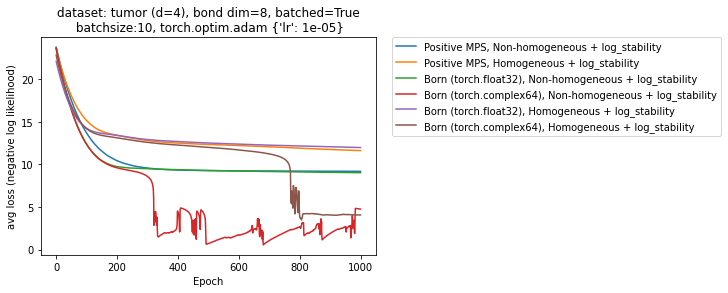

In [6]:
dataset = 'tumor'
X,d = load_dataset(dataset)
D = 8

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals = train_models(
    [mps_s_hom, rBorn_s_hom, cBorn_s_hom, mps_s, rBorn_s, cBorn_s],
    clamp_at=None, batchsize=10, max_epochs=1000, batched=True, optimizer=torch.optim.Adam, lr=1e-5)


╭──votes
│ data shape:(435, 17)
│ range of X values: 0 -- 2
╰───────────────────
dataset: votes
╭───────────────────────────batched=True
│Training Born (torch.complex64), Non-homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 1e-06}.



│ loss values: 18.658 18.647 18.636 18.625 18.614 18.605 18.595 18.583 18.575 18.562 18.552 18.543 18.532 18.521 18.512 18.501 18.492 18.480 18.471 18.461 18.453 18.440 18.431 18.420 18.412 18.402 18.391 18.380 18.371 18.361 18.351 18.342 18.330 18.321 18.314 18.305 18.292 18.282 18.272 18.265 18.255 18.246 18.235 18.224 18.215 18.205 18.197 18.187 18.177 18.167 18.159 18.147 18.140 18.127 18.120 18.113 18.100 18.093 18.083 18.074 18.063 18.054 18.046 18.035 18.027 18.017 18.008 17.998 17.989 17.980 17.971 17.964 17.950 17.944 17.935 17.925 17.917 17.906 17.896 17.893 17.878 17.870 17.861 17.854 17.844 17.835 17.826 17.815 17.808 17.798 17.790 17.781 17.773 17.764 17.754 17.748 17.736 17.728 17.718 17.712 17.704 17.695 17.685 17.676 17.674 17.659 17.649 17.645 17.631 17.625 17.614 17.606 17.598 17.590 17.581 17.574 17.563 17.555 17.548 17.538 17.530 17.522 17.513 17.507 17.496 17.488 17.476 17.470 17.464 17.456 17.445 17.440 17.432 17.428 17.413 17.404 17.395 17.386 17.383 17.377 17.3


│ loss values: 18.289 18.278 18.269 18.260 18.250 18.240 18.229 18.221 18.211 18.203 18.193 18.183 18.172 18.164 18.156 18.144 18.135 18.127 18.117 18.107 18.098 18.089 18.079 18.071 18.062 18.053 18.046 18.035 18.025 18.018 18.008 17.998 17.990 17.983 17.972 17.963 17.956 17.945 17.937 17.930 17.920 17.911 17.905 17.893 17.887 17.876 17.869 17.859 17.852 17.842 17.836 17.826 17.818 17.809 17.801 17.792 17.782 17.777 17.767 17.760 17.753 17.744 17.734 17.729 17.718 17.711 17.706 17.694 17.687 17.678 17.671 17.663 17.654 17.645 17.639 17.630 17.625 17.618 17.607 17.598 17.600 17.584 17.577 17.567 17.560 17.553 17.549 17.537 17.530 17.522 17.515 17.506 17.502 17.490 17.486 17.476 17.468 17.464 17.453 17.449 17.440 17.439 17.424 17.425 17.412 17.402 17.397 17.387 17.387 17.378 17.366 17.359 17.352 17.342 17.340 17.331 17.323 17.316 17.310 17.304 17.296 17.288 17.287 17.277 17.266 17.262 17.253 17.248 17.241 17.244 17.228 17.222 17.213 17.206 17.199 17.194 17.188 17.190 17.170 17.166 17.1

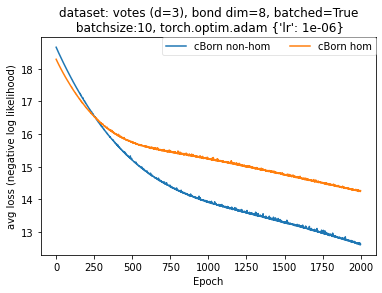

In [20]:
dataset = 'votes'
X,d = load_dataset(dataset)
D = 8

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

# mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
# mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
# rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
# rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)

lossvals = train_models(
    [#mps_s, mps_s_hom, rBorn_s, rBorn_s_hom, 
    cBorn_s, cBorn_s_hom],
    clamp_at=None, batchsize=10, max_epochs=2000, batched=True, optimizer=torch.optim.Adam, lr=1e-6)


╭──lymphography
│ data shape:(148, 19)
│ range of X values: 0 -- 7
╰───────────────────
dataset: lymphography
╭───────────────────────────batched=True
│Training Born (torch.float32), Non-homogeneous, on cpu
│         batchsize:10, torch.optim.adam, {'lr': 0.025}.


├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([19, 8, 8, 8])
│ loss values: 19.810 16.050 15.240 14.624 14.191 13.884 13.748 13.530 13.286 13.210 12.979 12.827 12.728 12.564 12.434 12.365 12.338 12.106 11.993 11.831 11.692 11.688 11.514 11.395 11.292 11.277 11.214 11.098 11.012 11.040 10.955 10.881 10.766 10.703 10.661 10.694 10.657 10.489 10.495 10.388 10.348 10.295 10.265 10.209 10.149 10.067 10.038 10.003 10.003 9.940 9.868 9.825 9.802 9.772 9.735 9.703 9.705 9.684 9.643 9.588 9.590 9.592 9.531 9.533 9.425 9.471 9.435 9.382 9.388 9.387 9.370 9.334 9.268 9.222 9.246 9.173 9.161 9.170 9.112 9.092 9.029 9.019 9.027 9.006 8.961 8.943 8.870 8.916 8.884 8.862 8.808 8.793 8.821 8.777 8.749 8.747 8.745 8.749 8.705 8.647 8.622 8.655 8.679 8.612 8.590 8.572 8.549 8.533 8.489 8.532 8.490 8.530 8.531 8.451 8.455 8.412 8.404 8.391 8.325 8.358 8.362 8.353 8.233 8.263 8.325

├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8, 8, 8])
│ loss values: 29.420 26.176 24.232 23.168 22.414 21.858 21.456 21.056 20.556 20.176 19.782 19.355 19.034 18.770 18.432 18.210 18.214 23.368 26.795 25.911 25.204 26.318 27.621 27.759 26.291 25.479 24.766 24.097 23.598 23.218 22.955 22.707 22.518 22.371 22.126 21.962 21.855 21.759 21.637 21.536 21.474 21.369 21.297 21.200 21.122 21.049 21.019 20.939 20.909 20.814 20.798 20.726 20.665 20.603 20.539 20.519 20.458 20.423 20.355 20.301 20.251 20.201 20.147 20.138 20.074 20.029 19.996 19.958 19.942 19.882 19.870 19.802 19.777 19.744 19.708 19.688 19.606 19.629 19.580 19.543 19.542 19.518 19.503 19.471 19.416 19.429 19.384 19.335 19.352 19.310 19.285 19.252 19.248 19.227 19.211 19.176 19.178 19.155 19.100 19.055 19.052 19.038 19.040 19.056 18.983 18.971 18.940 18.937 18.951 18.919 18.853 18.887 18.877 18.855 18.8

├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([19, 8, 8, 8])
│ loss values: 19.754 15.879 14.899 14.238 13.940 13.682 13.409 13.262 13.096 12.997 12.837 12.684 12.423 12.375 12.237 12.065 11.906 11.829 11.734 11.614 11.530 11.386 11.335 11.286 11.160 11.189 11.054 10.952 10.869 10.826 10.809 10.719 10.592 10.533 10.563 10.445 10.387 10.352 10.282 10.181 10.121 10.137 10.046 9.990 9.916 9.965 9.794 9.791 9.807 9.723 9.711 9.651 9.635 9.565 9.581 9.554 9.467 9.525 9.413 9.378 9.350 9.332 9.418 9.307 9.291 9.232 9.237 9.247 9.243 9.165 9.124 9.135 9.127 9.102 9.049 9.045 8.992 8.984 8.968 8.885 8.895 8.869 8.899 8.877 8.844 8.757 8.806 8.752 8.737 8.778 8.721 8.748 8.672 8.695 8.671 8.619 8.570 8.579 8.599 8.582 8.578 8.545 8.544 8.503 8.483 8.501 8.535 8.449 8.408 8.394 8.428 8.405 8.402 8.305 8.313 8.310 8.290 8.294 8.296 8.253 8.208 8.223 8.251 8.213 8.220 8.165

├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8, 8, 8])
│ loss values: 28.681 25.798 26.069 25.488 24.516 23.526 22.784 22.241 21.880 21.599 21.345 21.059 20.843 20.712 20.382 20.088 19.825 19.546 19.262 19.001 18.758 18.466 18.152 17.874 17.542 17.279 17.055 16.873 16.612 16.505 16.297 16.129 15.977 16.002 15.819 15.671 15.538 15.480 15.389 15.366 15.245 15.199 15.234 15.195 15.542 15.337 15.680 15.690 15.298 15.091 14.968 14.883 14.830 14.754 14.729 14.705 14.646 14.605 14.620 14.560 14.550 14.556 14.504 14.455 14.457 14.399 14.405 14.369 14.345 14.332 14.321 14.297 14.296 14.257 14.284 14.226 14.217 14.196 14.177 14.132 14.110 14.121 14.119 14.065 14.107 14.048 14.040 14.043 14.005 13.993 13.961 13.949 13.900 13.924 13.870 13.876 13.850 13.817 13.879 13.868 13.805 13.776 13.787 13.828 13.834 13.795 13.726 13.754 13.724 13.730 13.793 13.675 13.665 13.697 13.6

├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([19, 8, 8, 8])
│ loss values: 19.947 16.009 15.019 14.581 14.078 13.872 13.547 13.401 13.398 13.179 12.969 12.790 12.701 12.502 12.467 12.299 12.221 12.196 12.010 11.868 11.709 11.640 11.533 11.496 11.335 11.246 11.139 11.109 11.055 11.016 10.892 10.880 10.794 10.724 10.685 10.617 10.598 10.522 10.465 10.502 10.350 10.306 10.254 10.206 10.192 10.174 9.992 9.873 9.886 9.796 9.797 9.723 9.735 9.683 9.663 9.595 9.627 9.569 9.489 9.443 9.402 9.377 9.380 9.378 9.381 9.325 9.286 9.279 9.221 9.209 9.223 9.170 9.172 9.146 9.109 9.060 9.032 9.010 8.981 8.983 8.973 8.940 8.915 8.899 8.894 8.824 8.821 8.855 8.816 8.807 8.812 8.763 8.770 8.747 8.684 8.638 8.654 8.726 8.607 8.584 8.568 8.562 8.627 8.573 8.562 8.562 8.523 8.551 8.486 8.506 8.490 8.543 8.512 8.403 8.395 8.416 8.381 8.354 8.323 8.338 8.352 8.287 8.288 8.261 8.238 8.

├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8])
├─NaN value in gradient of right_boundary, torch.Size([8, 8, 8])
│ loss values: 28.421 25.187 23.315 22.495 21.911 21.504 21.165 20.839 20.471 19.992 19.626 19.304 19.089 18.689 18.495 18.145 17.788 17.525 17.300 17.986 18.314 21.828 25.054 24.265 23.190 22.484 22.054 21.650 21.337 21.139 20.939 20.764 20.677 20.535 20.399 20.276 20.151 20.086 19.950 19.835 19.788 19.689 19.557 19.484 19.404 19.302 19.200 19.157 19.067 18.947 18.869 18.835 19.346 21.848 23.925 22.872 22.185 21.653 21.332 21.044 20.850 20.774 20.452 20.223 20.092 19.935 19.865 19.704 19.626 19.540 19.447 19.383 19.366 19.270 19.187 19.126 19.088 18.998 18.955 18.893 18.880 18.805 18.745 18.689 18.658 18.603 18.575 18.520 18.495 18.434 18.397 18.328 18.318 18.247 18.224 18.219 18.173 18.116 18.064 18.032 18.013 17.953 17.907 17.894 17.842 17.814 17.752 17.742 17.709 17.663 17.648 17.582 17.542 17.518 17.4

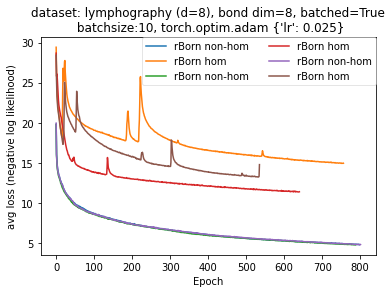

In [19]:
dataset = 'lymphography'
X,d = load_dataset(dataset)
D = 8

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

# mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
# mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
arBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
arBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
brBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
brBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
crBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
crBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e8)
# cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1)
# cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1)

lossvals = train_models(
    [arBorn_s, arBorn_s_hom, brBorn_s, brBorn_s_hom, crBorn_s, crBorn_s_hom, 
    # cBorn_s, cBorn_s_hom
    ],
    clamp_at=None, batchsize=10, max_epochs=1000, batched=True, optimizer=torch.optim.Adam, lr=2.5e-2)

In [26]:
dataset = 'biofam'
X,d = load_dataset(dataset)
D = 2

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

Bmps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
Bmps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
BrBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
BrBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
BcBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=10)
BcBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=10)

lossvals_biofam = train_models(
    [Bmps_s, Bmps_s_hom, BrBorn_s, BrBorn_s_hom, 
    cBorn_s, cBorn_s_hom
    ],
    clamp_at=None, batchsize=50, max_epochs=1000, batched=True, verbose=False, optimizer=torch.optim.Adam, lr=1e-3)

╭──biofam
│ data shape:(2000, 16)
│ range of X values: 0 -- 7
╰───────────────────
dataset: biofam
╭───────────────────────────batched=True
│Training Positive MPS, Non-homogeneous, on cpu
│         batchsize:50, torch.optim.adam, {'lr': 0.001}.


KeyboardInterrupt: 

In [ ]:
dataset = 'biofam'
X,d = load_dataset(dataset)
D = 8

wr = 'noisy' # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=1e10)
# cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr, gradient_clipping_threshold=10)
# cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr, gradient_clipping_threshold=10)

lossvals_biofam = train_models(
    [mps_s, mps_s_hom, rBorn_s, rBorn_s_hom, 
    #cBorn_s, cBorn_s_hom
    ],
    clamp_at=None, batchsize=10, max_epochs=500, batched=True, verbose=False, optimizer=torch.optim.Adam, lr=1e-3)

## Useful things?

In [ ]:
# Testing item selection

d=6
bs=3
slen=5
D=2

X = torch.randint(d,(bs,slen))
print(X)
weights = torch.arange(bs*slen*d*D*D).view(bs,slen,d,D,D)#.type(torch.cfloat)
# print(weights)
# what we want to do is, 
# in the bth batch and the ith core, 
# choose the X[b,i]th weight element
print("Selected weight items:")
for b, _ in enumerate(weights):
    for i, _ in enumerate(weights[b]):
        print(weights[b,i,X[b,i]])
    print()

# using a one-hot encoding of X, a tensor Xh of shape [bs,slen,d]
Xh = torch.nn.functional.one_hot(X, num_classes=d)
print("weights' shape", weights.shape)
print("1hot obs shape", Xh.shape)
# for b,_ in enumerate(ww):
#     print((ww[b] * XXh[b][:, :,None,None]).sum(1))
selected = (weights * Xh[:, :, :, None, None]).sum(2)
print("Selected weight items:")
print(selected.shape)
print(selected)

In [ ]:
# # torch.autograd.set_detect_anomaly(True)
# def train(self, dataset, batchsize, max_epochs, plot=True, **optim_kwargs):
#     trainloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
#     optimizer = torch.optim.Adadelta(self.parameters(), **optim_kwargs)
#     early_stopping_threshold = 1e-6 # min difference in epoch loss 
#     loss_values = [] # store by-epoch avg loss values
#     print(f'╭───────────────────────────\n│Training {self.name},')
#     print(f'│         batchsize:{batchsize}, {optimizer.__module__}, {optim_kwargs}.')
#     av_batch_loss_running = -1e4
#     with tqdm(range(max_epochs), unit="epoch", leave=True) as tepochs:
#         for epoch in tepochs:
#             batch_loss_list = []
#             with tqdm(trainloader, unit="batch", leave=False, desc=f"epoch {epoch}") as tepoch:
#                 for batch in tepoch:
#                     for pindex, p in enumerate(self.parameters()):
#                         if torch.isnan(p).any():
#                             pnames = list(self.state_dict().keys())
#                             print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
#                             print(f"└────Stopped before epoch {epoch}. NaN in weights {pnames[pindex]}!")
#                             if plot:
#                                 plt.plot(loss_values)
#                                 plt.show()
#                             return loss_values
#                     self.zero_grad()
#                     neglogprob = 0
#                     for x in batch:
#                         out = self(x)
#                         neglogprob -= out
#                     loss = neglogprob / len(batch)
#                     loss.backward()
#                     # for pindex, p in enumerate(self.parameters()):
#                     #     if torch.isnan(p.grad).any():
#                     #         pnames = list(self.state_dict().keys())
#                     #         print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
#                     #         print(f"└────Stopped. NaN value in gradient for {pnames[pindex]}!")
#                     #         if plot:
#                     #             plt.plot(loss_values)
#                     #             plt.show()
#                     #         return loss_values
#                     optimizer.step()
#                     tepoch.set_postfix(loss=loss.item())
#                     batch_loss_list.append(loss.item())
#                 av_batch_loss = torch.Tensor(batch_loss_list).mean().item()
#                 loss_values.append(av_batch_loss)
#                 tepochs.set_postfix(av_batch_loss=av_batch_loss)
#                 if abs(av_batch_loss_running - av_batch_loss) < early_stopping_threshold:
#                     print(f"├────Early stopping after epoch {epoch}/{max_epochs}.")
#                     break
#                 av_batch_loss_running = av_batch_loss
#     print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
#     if plot:
#         plt.plot(loss_values)
#         plt.show()
#     print('│ Finished training.\n╰───────────────────────────\n')
#     return loss_values

# def train_models(models, batchsize, max_epochs, **optim_kwargs):
#     print(f"dataset: {dataset}")
#     models_loss_values={}
#     for model in models:
#         loss_values = train(model, X, batchsize=batchsize, plot=False, max_epochs = max_epochs, **optim_kwargs)
#         plt.plot(loss_values, label=model.name)
#         plt.ylabel('avg loss (NLL)')
#         plt.xlabel('Epoch')
#         plt.title(f"dataset: {dataset} (d={d}), bond dim={D}\n batchsize:{batchsize}, {optim_kwargs}")
#         models_loss_values[f"{model.name}"]=loss_values
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#     plt.show()
#     return models_loss_values

In [ ]:

# def clip_grad(grad, clip_val, param_name, verbose=False):
#     """Clip the gradients, to be used as a hook during training."""
#     if torch.isnan(grad).any():
#         print(f"├─NaN value in gradient of {param_name}, {grad.size()}")
#     if grad.dtype==torch.cfloat:
#         for ext, v in [("min", grad.real.min()),("max", grad.real.max())]:
#             if verbose and abs(v) > clip_val:
#                 print(f"│(clipping {param_name} real {ext} {v:.2} to size {clip_val})")
#         for ext, v in [("min", grad.imag.min()),("max", grad.imag.max())]:
#             if verbose and abs(v) > clip_val:
#                 print(f"│(clipping {param_name} imag {ext} {1.j*v:.2} to size {clip_val})")
#         clipped_grad = torch.complex(grad.real.clamp(-clip_val, clip_val),
#                                      grad.imag.clamp(-clip_val, clip_val))
#     else:
#         for ext, v in [("min", grad.min()),("max", grad.max())]:
#             if verbose and abs(v) > clip_val:
#                 print(f"│(clipping {param_name} {ext} {v:.2} to size {clip_val})")
#         clipped_grad = torch.clamp(grad, -clip_val, clip_val)
#     return clipped_grad

# print(f"Models: D={D}, d={d}")
# for model in (*models, *models_hom):
#     print(f"\t{model.core.shape} model type: {model.name}")
#     for param_index, p in enumerate(model.parameters()):
#         pnames = list(model.state_dict().keys())
#         p.register_hook(lambda grad: clip_grad(grad, 1000, pnames[param_index], verbose=True))
#         if torch.isnan(p).any():
#             print(f"{pnames[param_index]} contains a NaN value!")



In [ ]:
# dataset = 'biofam'
# X,d = load_dataset(dataset)
# D = 8

# wr = noisy # choose either None, 'noisy', or 'random_angle' or 'gaussian_zeros'

# mps      = PosMPS(X, d, D,                     homogeneous=False, log_stability=False,  w_randomization=wr)
# mps_hom  = PosMPS(X, d, D,                     homogeneous=True,  log_stability=False,  w_randomization=wr)
# mps_s    = PosMPS(X, d, D,                     homogeneous=False, log_stability=True,   w_randomization=wr)
# mps_s_hom= PosMPS(X, d, D,                     homogeneous=True,  log_stability=True,   w_randomization=wr)
# rBorn      = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=False,  w_randomization=wr) 
# rBorn_hom  = Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=False,  w_randomization=wr)
# rBorn_s    = Born(X, d, D, dtype=torch.float,  homogeneous=False, log_stability=True,   w_randomization=wr)
# rBorn_s_hom= Born(X, d, D, dtype=torch.float,  homogeneous=True,  log_stability=True,   w_randomization=wr)
# cBorn      = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=False,  w_randomization=wr)
# cBorn_hom  = Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=False,  w_randomization=wr)
# cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True,   w_randomization=wr)
# cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True,  log_stability=True,   w_randomization=wr)

# models     = (
#     # rBorn, cBorn, mps, 
#     rBorn_s, cBorn_s, mps_s)
# models_hom = (
#     # rBorn_hom, cBorn_hom, mps_hom, 
#     rBorn_s_hom, cBorn_s_hom, mps_s_hom)
